### Начало

# Импорт библиотек

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU, BatchNormalization
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.optimizers import Adam
from keras.regularizers import l2

# Работа с датасетом

In [52]:
df = pd.read_csv('Titanic.csv').drop('PassengerId', axis=1) # Читаем датасет и сразу отбрасываем лишний столбик с ID пассажира, который никак не дает никакой информации.
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


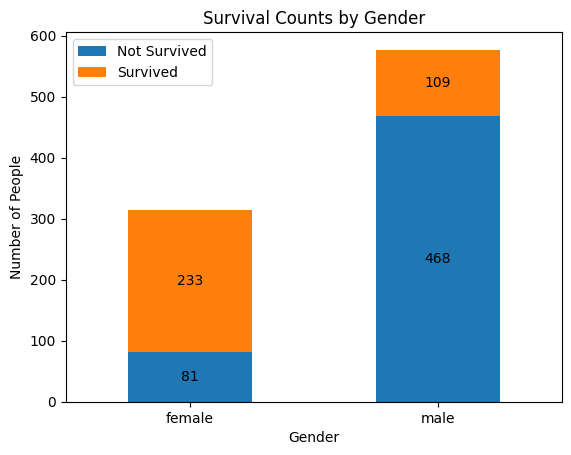

In [53]:
survival_stats = df.groupby(['Sex', 'Survived']).size().unstack() # Группирует пол и выживаемость в таблицу
ax = survival_stats.plot(kind='bar', stacked=True) # Формируем диаграмму из таблицы

plt.title('Survival Counts by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of People')
plt.xticks(rotation=0)
plt.legend(['Not Survived', 'Survived'])
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.show()

Женщины при меньшем количестве - выживали чаще, чем мужчины. Посмотрим более наглядно на проценты


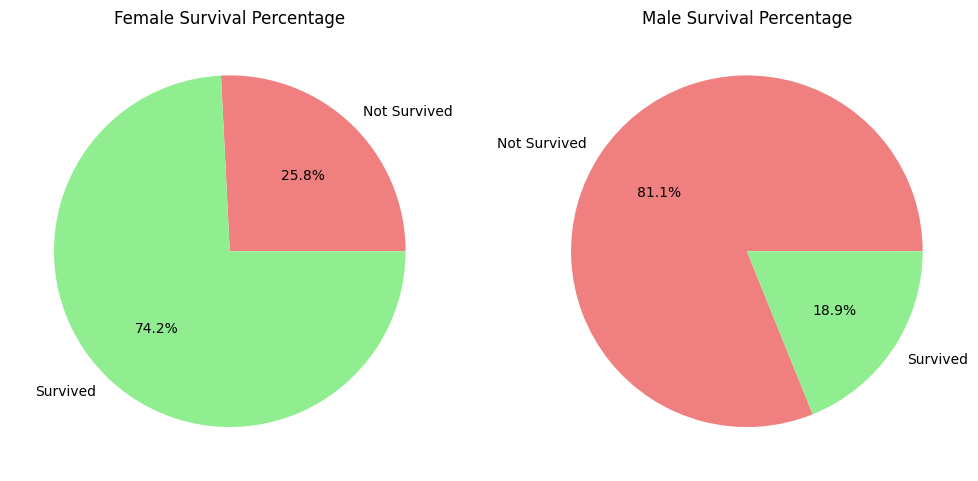

In [54]:
percentage = survival_stats.div(survival_stats.sum(axis=1), axis=0)
plt.figure(figsize=(10, 5))

# Настройка круговой диаграммы для женщин
plt.subplot(1, 2, 1)
plt.pie(percentage.loc['female'].values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Female Survival Percentage')

# Настройка круговой диаграммы для мужчин
plt.subplot(1, 2, 2)
plt.pie(percentage.loc['male'].values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('Male Survival Percentage')

plt.tight_layout()
plt.show()

Здесь мы можем увидеть, что только каждая 4 женщина умирала, в то время как только каждый 6 мужчина выживал. Тоесть шанс мужчины умереть был в разы больше


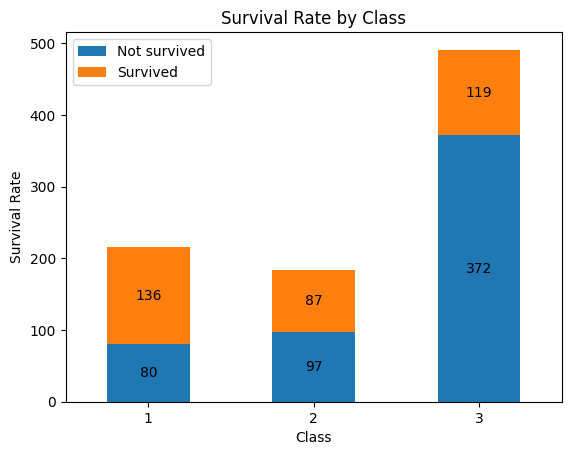

In [55]:
survival_stats = df.groupby(['Pclass', 'Survived']).size().unstack() #Группируем по классу и выжившим/невыжившим
ax = survival_stats.plot(kind='bar', stacked=True)
plt.title('Survival Rate by Class')
plt.xlabel('Class')
plt.ylabel('Survival Rate')
plt.xticks(rotation=0)
plt.legend(['Not survived', 'Survived'])
for container in ax.containers:
    ax.bar_label(container, label_type='center')
plt.show()

На этой диаграмме можем увидеть выживаемость среди людей разных классов. Чем выше класс у человека тем выше шанс что он выживет. Посмотрим немного нагляднее.

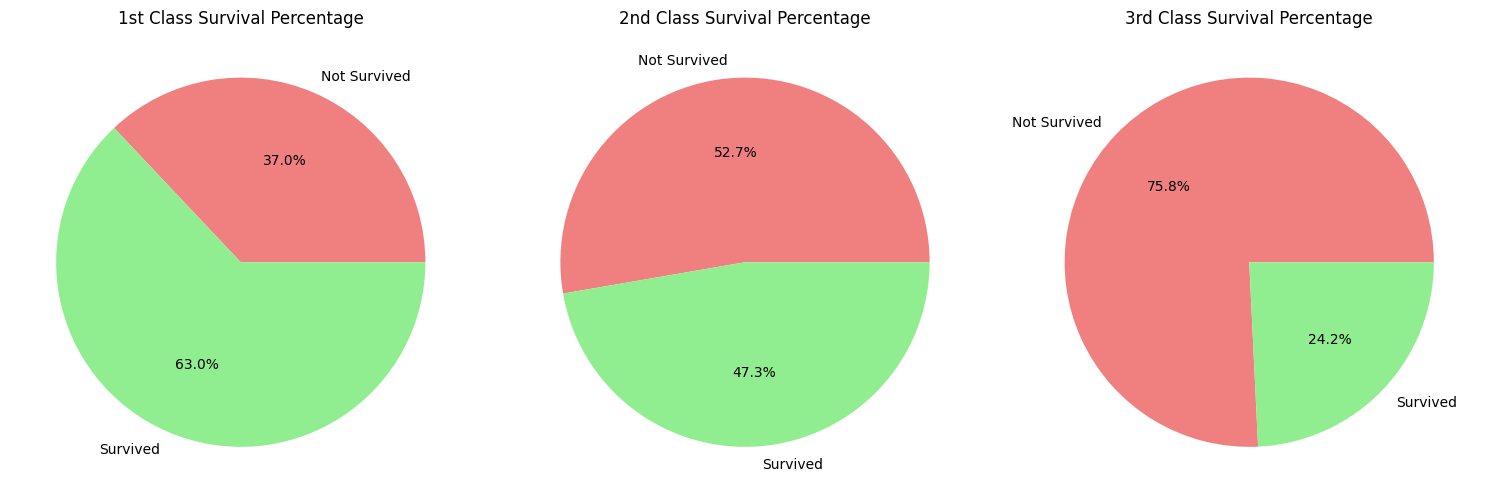

In [56]:
percentage = survival_stats.div(survival_stats.sum(axis=1), axis=0) * 100

plt.figure(figsize=(15, 5))

# Круговая диаграмма для пассажиров 1-го класса
plt.subplot(1, 3, 1)
plt.pie(percentage.loc[1].values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('1st Class Survival Percentage')

# Круговая диаграмма для пассажиров 2-го класса
plt.subplot(1, 3, 2)
plt.pie(percentage.loc[2].values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('2nd Class Survival Percentage')

# Круговая диаграмма для пассажиров 3-го класса
plt.subplot(1, 3, 3)
plt.pie(percentage.loc[3].values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'])
plt.title('3rd Class Survival Percentage')

# Отображение диаграмм
plt.tight_layout()
plt.show()

Тут наглядно видно что с ростом класса, растет и шанс на выживание у человека



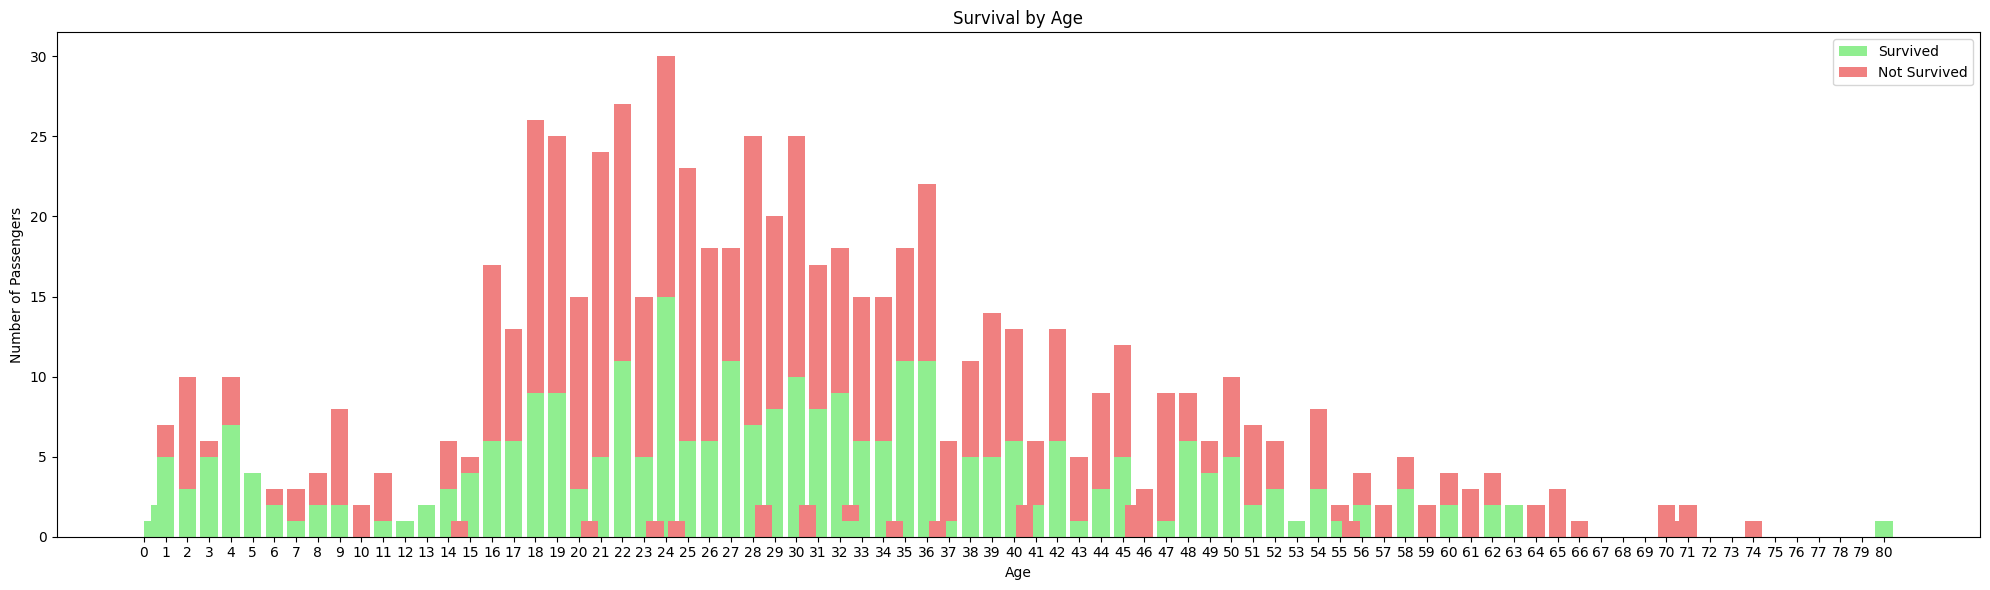

In [57]:
df_clean = df.dropna(subset=['Age']) # Удалим строки с пропущенными значениями в столбце Age
age_grouped = df_clean.groupby(['Age', 'Survived']).size().unstack(fill_value=0) # Группируем данные по возрасту и выжившим/невыжившим

plt.figure(figsize=(20, 6))
plt.bar(age_grouped.index, age_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(age_grouped.index, age_grouped[0], label='Not Survived', bottom=age_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)
plt.xticks(np.arange(0, df_clean['Age'].max() + 1, 1))
plt.title('Survival by Age')
plt.xlabel('Age')
plt.ylabel('Number of Passengers')
plt.legend()
plt.tight_layout()
plt.show()

По данному графику тяжело сделать какие то выводы, можем сказать только то что некоторые значения не попадают в целые числа, из-за чего график немного ломается, сгруппируем возраст по 10 лет.


<ipython-input-58-4ecb7b8c5dd6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Age Group'] = pd.cut(df_clean['Age'], bins=range(0, 81, 10))
<ipython-input-58-4ecb7b8c5dd6>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_grouped_by_decade = df_clean.groupby(['Age Group', 'Survived']).size().unstack(fill_value=0)


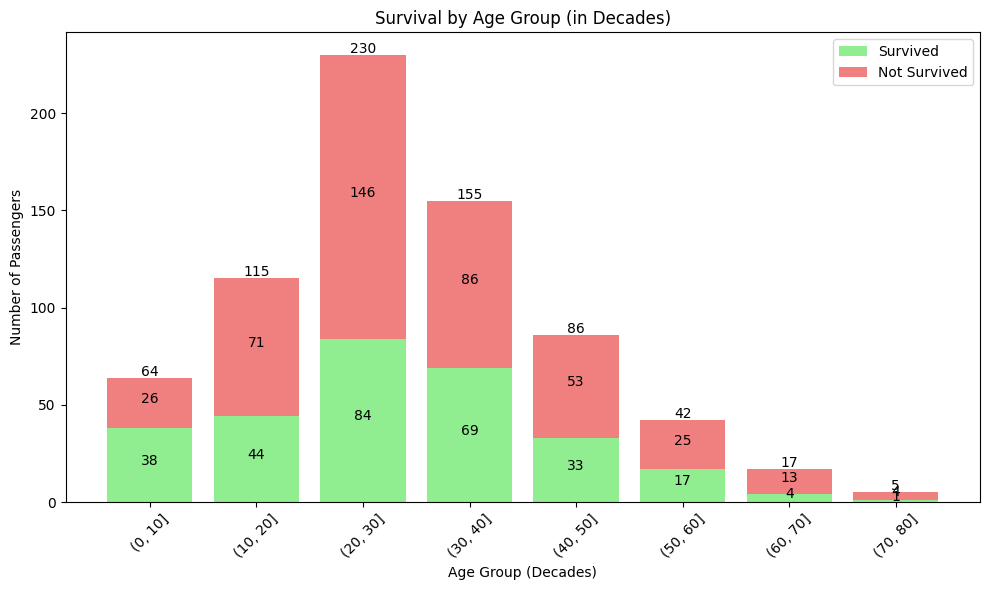

In [58]:
df_clean['Age Group'] = pd.cut(df_clean['Age'], bins=range(0, 81, 10))
age_grouped_by_decade = df_clean.groupby(['Age Group', 'Survived']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
plt.bar(age_grouped_by_decade.index.astype(str), age_grouped_by_decade[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(age_grouped_by_decade.index.astype(str), age_grouped_by_decade[0], label='Not Survived', bottom=age_grouped_by_decade[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

for idx, (survived, not_survived) in enumerate(zip(age_grouped_by_decade[1], age_grouped_by_decade[0])):
    plt.text(idx, survived + not_survived + 1, str(survived + not_survived), ha='center')  # Общая сумма
    plt.text(idx, survived / 2, str(survived), ha='center')  # Выжившие
    plt.text(idx, survived + not_survived / 2, str(not_survived), ha='center') # Не выжившие

plt.title('Survival by Age Group (in Decades)')
plt.xlabel('Age Group (Decades)')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Здесь видно все более наглядно, но какой либо точный вывод так-же сделать тяжело. Сделаем этот график еще более наглядным. По графику люди в группе от 20-30 преобладают, но их выживаемость точно меньше чем у группы 0-10. Посмотрим все в процентах



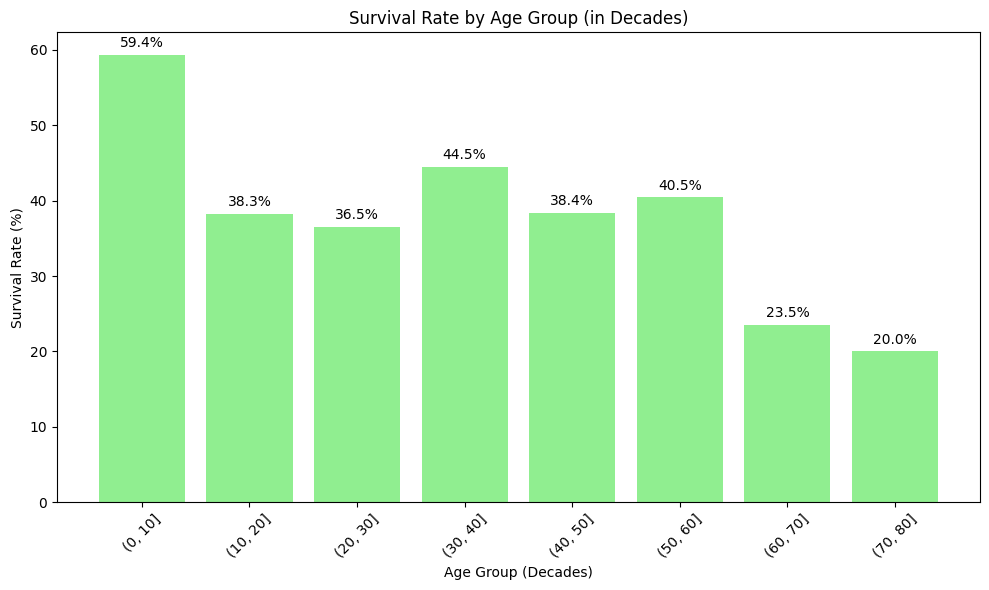

In [59]:
age_grouped_by_decade['Survival Rate (%)'] = (age_grouped_by_decade[1] / (age_grouped_by_decade[0] + age_grouped_by_decade[1])) * 100

plt.figure(figsize=(10, 6))
plt.bar(age_grouped_by_decade.index.astype(str), age_grouped_by_decade['Survival Rate (%)'], color='lightgreen') # Столбчатая диаграмма для процента выживших

# Добавление числовых значений (процентов) над столбцами
for idx, percent in enumerate(age_grouped_by_decade['Survival Rate (%)']):
    plt.text(idx, percent + 1, f'{percent:.1f}%', ha='center')

plt.title('Survival Rate by Age Group (in Decades)')
plt.xlabel('Age Group (Decades)')
plt.ylabel('Survival Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

На этом графике мы уже точно можем увидеть, что дети в возрасте от 0-10 лет выживают гораздо чаще чем другие группы. Все остальные имеют +- одинаковый шанс, кроме более старах групп, их шансы резко падают



<ipython-input-60-8e77cdfae4d4>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_grouped = df_clean.groupby(['Fare Group', 'Survived']).size().unstack(fill_value=0) # Группируем по стоимости билета и выжившим/невыжившим


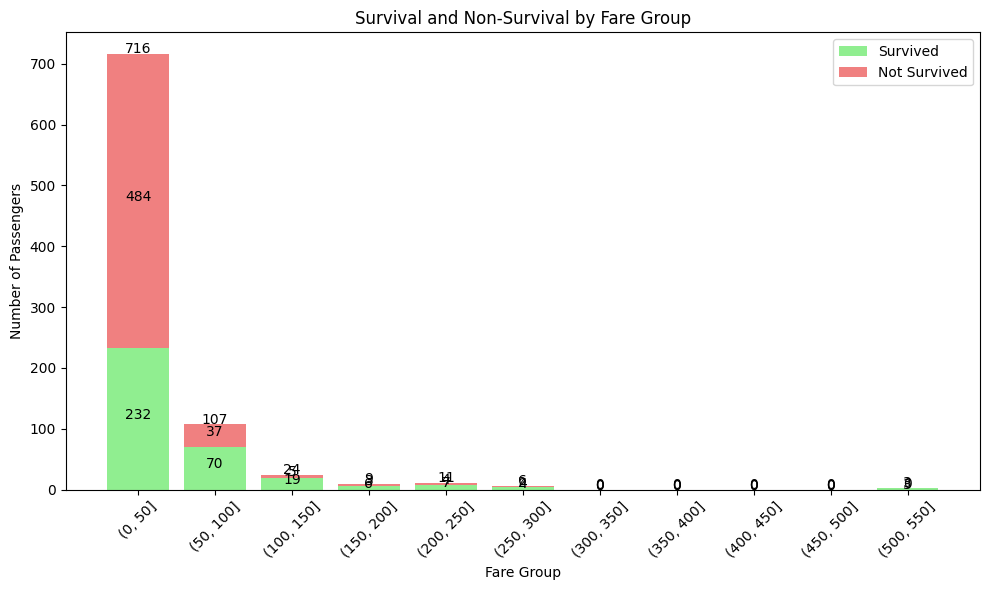

In [60]:
df_clean = df.dropna(subset=['Fare']) # Удалим строки с пропущенными значениями в столбце Fare
df_clean['Fare Group'] = pd.cut(df_clean['Fare'], bins=range(0, int(df_clean['Fare'].max()) + 50, 50)) # Создаем столбец для группировки стоимости билетов с шагом в 50 единиц
fare_grouped = df_clean.groupby(['Fare Group', 'Survived']).size().unstack(fill_value=0) # Группируем по стоимости билета и выжившим/невыжившим

plt.figure(figsize=(10, 6))
plt.bar(fare_grouped.index.astype(str), fare_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(fare_grouped.index.astype(str), fare_grouped[0], label='Not Survived', bottom=fare_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление числовых значений над столбцами
for idx, (survived, not_survived) in enumerate(zip(fare_grouped[1], fare_grouped[0])):
    plt.text(idx, survived + not_survived + 1, str(survived + not_survived), ha='center')  # Общее количество
    plt.text(idx, survived / 2, str(survived), ha='center')  # Выжившие
    plt.text(idx, survived + not_survived / 2, str(not_survived), ha='center')  # Не выжившие

plt.title('Survival and Non-Survival by Fare Group')
plt.xlabel('Fare Group')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Здесь я решил посмотреть на выживаемость в зависимости от стоимости билетов, сгруппировав их на определенные группы, но такой график не совсем коректен, потому что позднее я увидел что некоторые билеты повторяются и являются групповыми и стоимость таких билетов должна делиться на всю группу. Позднее сделаем и это


<ipython-input-61-d7879203513c>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_grouped = df_clean.groupby(['Fare Group', 'Survived']).size().unstack(fill_value=0) # Группируем по стоимости билета и выжившим/невыжившим


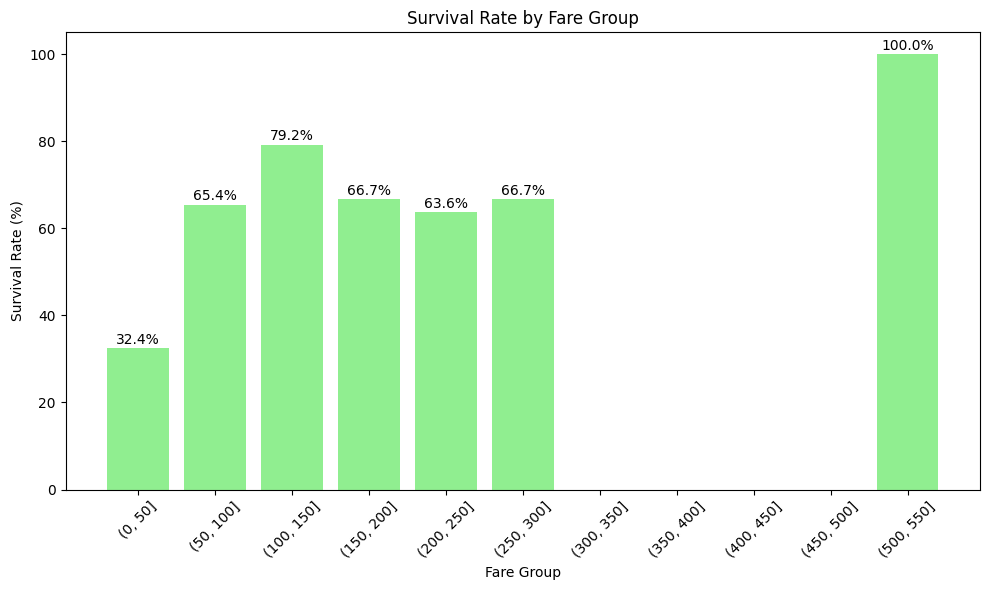

In [61]:
df_clean['Fare Group'] = pd.cut(df_clean['Fare'], bins=range(0, int(df_clean['Fare'].max()) + 50, 50)) # Создаем столбец для группировки стоимости билетов с шагом в 50 единиц
fare_grouped = df_clean.groupby(['Fare Group', 'Survived']).size().unstack(fill_value=0) # Группируем по стоимости билета и выжившим/невыжившим
fare_grouped['Survival Rate (%)'] = (fare_grouped[1] / (fare_grouped[0] + fare_grouped[1])) * 100 # Рассчитываем процент выживших в каждой группе стоимости билета

plt.figure(figsize=(10, 6))
plt.bar(fare_grouped.index.astype(str), fare_grouped['Survival Rate (%)'], color='lightgreen') # Столбчатая диаграмма для процента выживших по группам стоимости билета

# Добавление числовых значений (процентов) над столбцами
for idx, percent in enumerate(fare_grouped['Survival Rate (%)']):
    plt.text(idx, percent + 1, f'{percent:.1f}%', ha='center')

plt.title('Survival Rate by Fare Group')
plt.xlabel('Fare Group')
plt.ylabel('Survival Rate (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Здесь я решил посмотреть на прошлый график в процентах, но он тоже не особо корректен, по той же причине что была описана сверху


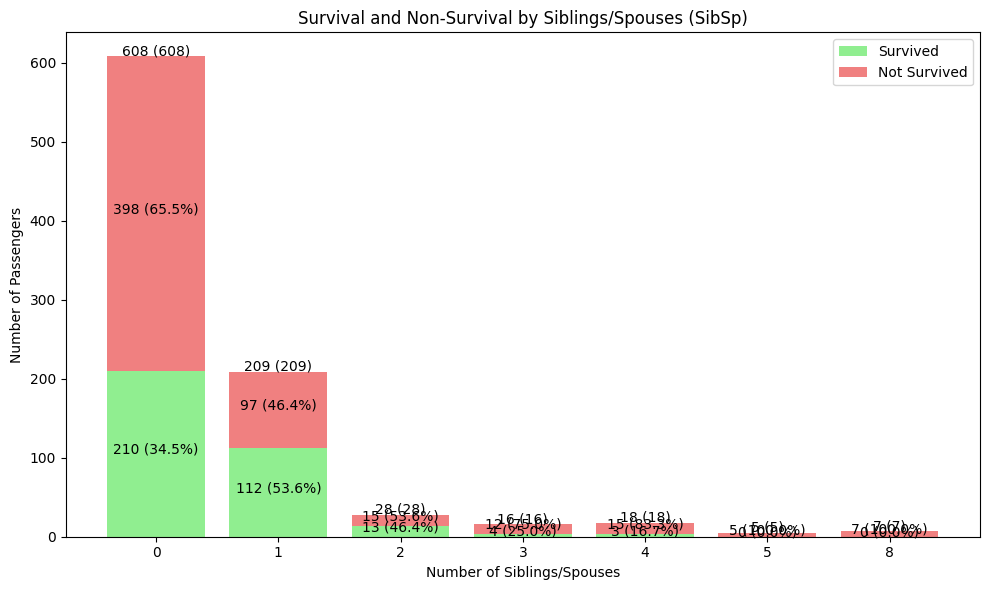

In [62]:
sibsp_grouped = df.groupby(['SibSp', 'Survived']).size().unstack(fill_value=0) # Группируем по количеству сестер и братьев и выжившим/невыжившим
sibsp_percent = sibsp_grouped.div(sibsp_grouped.sum(axis=1), axis=0) * 100 # Вычисление процентов

plt.figure(figsize=(10, 6))
plt.bar(sibsp_grouped.index.astype(str), sibsp_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(sibsp_grouped.index.astype(str), sibsp_grouped[0], label='Not Survived', bottom=sibsp_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление процентных значений над столбцами
for idx, (survived, not_survived) in enumerate(zip(sibsp_grouped[1], sibsp_grouped[0])):
    total = survived + not_survived
    plt.text(idx, survived + not_survived + 1, f'{total} ({total})', ha='center')  # Общее количество
    plt.text(idx, survived / 2, f'{survived} ({sibsp_percent.loc[sibsp_grouped.index[idx], 1]:.1f}%)', ha='center')  # Выжившие
    plt.text(idx, survived + not_survived / 2, f'{not_survived} ({sibsp_percent.loc[sibsp_grouped.index[idx], 0]:.1f}%)', ha='center')  # Не выжившие

plt.title('Survival and Non-Survival by Siblings/Spouses (SibSp)')
plt.xlabel('Number of Siblings/Spouses')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Я начал анализировать выживаемость в зависимости от родственников на борту. Сначала посмотрел на выживаемость людей с сестрами и братьями. Тут я сразу строю графики с процентами, чтобы не делать по несколько графиков на каждый из доводов. Тут больше всего шансов у тех у кого 1 брат или сестра на борту


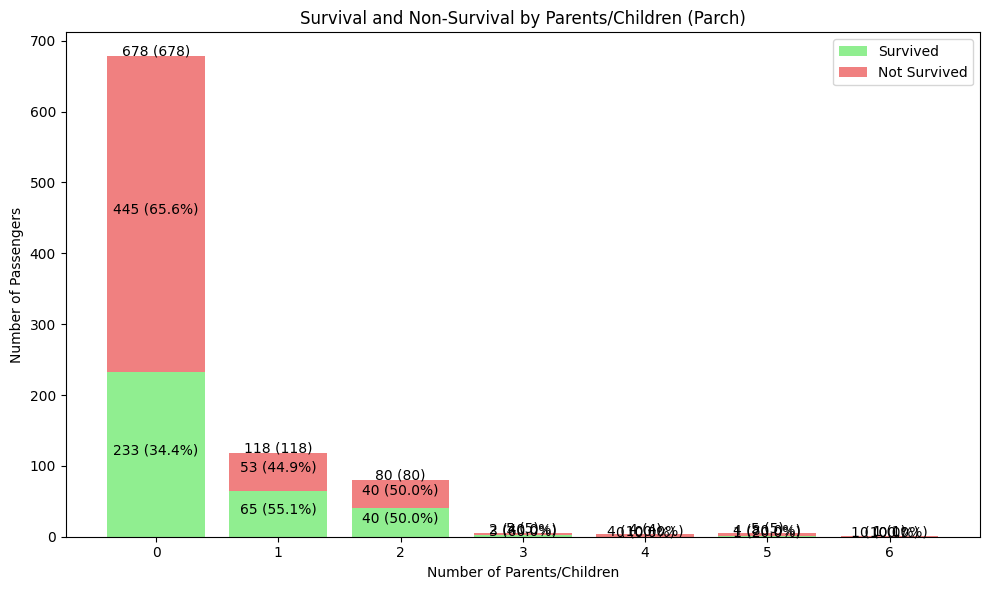

In [63]:
parch_grouped = df.groupby(['Parch', 'Survived']).size().unstack(fill_value=0) # Группируем по количеству родителей и детей и выжившим/невыжившим

parch_percent = parch_grouped.div(parch_grouped.sum(axis=1), axis=0) * 100 # Вычисление процентов

plt.figure(figsize=(10, 6))

plt.bar(parch_grouped.index.astype(str), parch_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(parch_grouped.index.astype(str), parch_grouped[0], label='Not Survived', bottom=parch_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление процентных значений над столбцами
for idx, (survived, not_survived) in enumerate(zip(parch_grouped[1], parch_grouped[0])):
    total = survived + not_survived
    plt.text(idx, survived + not_survived + 1, f'{total} ({total})', ha='center')  # Общее количество
    plt.text(idx, survived / 2, f'{survived} ({parch_percent.loc[parch_grouped.index[idx], 1]:.1f}%)', ha='center')  # Выжившие
    plt.text(idx, survived + not_survived / 2, f'{not_survived} ({parch_percent.loc[parch_grouped.index[idx], 0]:.1f}%)', ha='center')  # Не выжившие

plt.title('Survival and Non-Survival by Parents/Children (Parch)')
plt.xlabel('Number of Parents/Children')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Далее посмотрел в зависимости от родителей и детей. Тут нет особых расхождений сс графиком выше. Все +- на том же уровне. Поэтому я решил объеденить эти графики, чтобы облегчить работу нейросети и уменьшить количество данных. Тут видим что больше всего шансов у тех у есть 1 родитель или ребенок на борту.


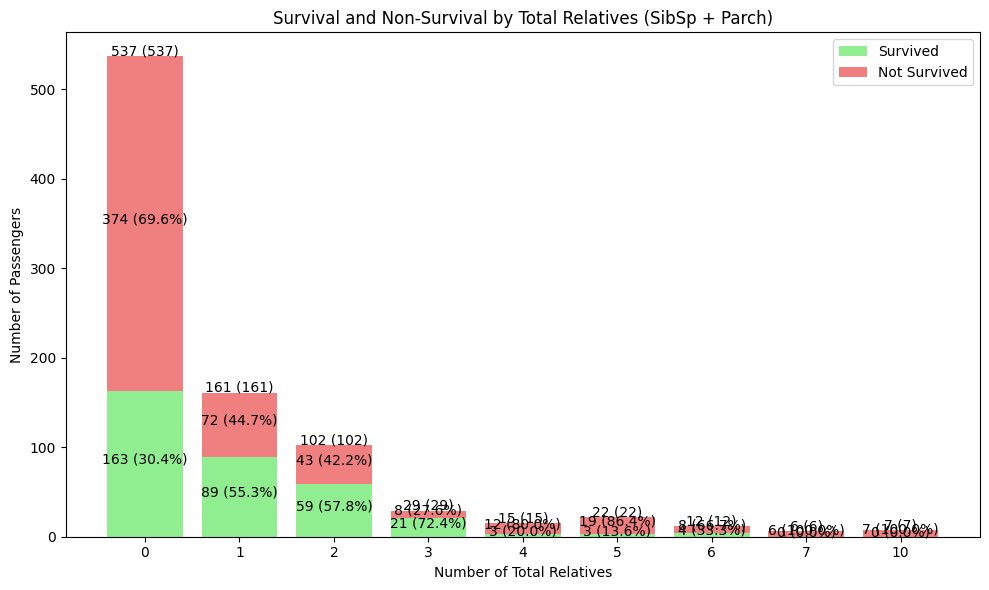

In [64]:
df['Relatives'] = df['SibSp'] + df['Parch'] # Добавляем столбец с общим количеством родственников

relatives_grouped = df.groupby(['Relatives', 'Survived']).size().unstack(fill_value=0) # Группируем по количеству родственников и выжившим/невыжившим

relatives_percent = relatives_grouped.div(relatives_grouped.sum(axis=1), axis=0) * 100 # Вычисление процентов

plt.figure(figsize=(10, 6))

plt.bar(relatives_grouped.index.astype(str), relatives_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(relatives_grouped.index.astype(str), relatives_grouped[0], label='Not Survived', bottom=relatives_grouped[1], color='lightcoral')# Гистограмма для невыживших (Survived = 0)

# Добавление процентных значений над столбцами
for idx, (survived, not_survived) in enumerate(zip(relatives_grouped[1], relatives_grouped[0])):
    total = survived + not_survived
    plt.text(idx, survived + not_survived + 1, f'{total} ({total})', ha='center')  # Общее количество
    plt.text(idx, survived / 2, f'{survived} ({relatives_percent.loc[relatives_grouped.index[idx], 1]:.1f}%)', ha='center')  # Выжившие
    plt.text(idx, survived + not_survived / 2, f'{not_survived} ({relatives_percent.loc[relatives_grouped.index[idx], 0]:.1f}%)', ha='center')  # Не выжившие

plt.title('Survival and Non-Survival by Total Relatives (SibSp + Parch)')
plt.xlabel('Number of Total Relatives')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Объеденил 2 значения и получиил новый столбец в датафрейме. Вывел закономерность выживаемости от количества родственников. Больше всего шансов у тех у кого 1 или 2 родственника на борту, у остальных они гораздо меньше



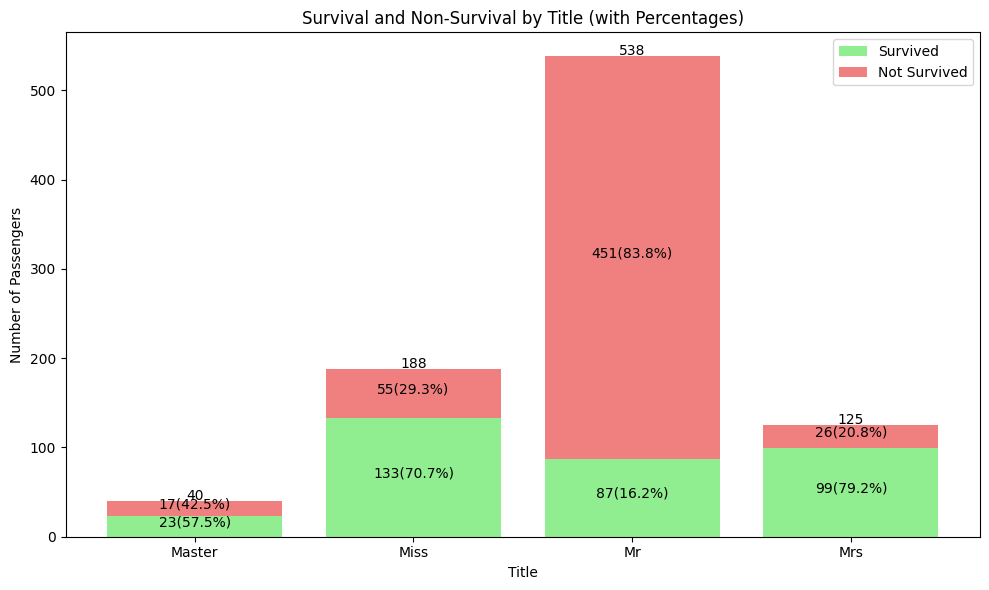

In [65]:
# Извлечение титулов из столбца 'Name'
df['Title'] = df['Name'].str.extract(r',\s*([^\.]*)\.')

# Замена редких титулов на общие категории
df['Title'] = df['Title'].replace(['Mlle', 'Ms', 'Lady', 'the Countess', 'Mme', 'Dona'], 'Miss')
df['Title'] = df['Title'].replace(['Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer'], 'Mr')

title_grouped = df.groupby(['Title', 'Survived']).size().unstack(fill_value=0) # Группировка по титулу и выжившим/невыжившим

# Рассчитываем проценты для каждой категории
title_grouped['Total'] = title_grouped[0] + title_grouped[1]
title_grouped['Survived (%)'] = (title_grouped[1] / title_grouped['Total']) * 100
title_grouped['Not Survived (%)'] = (title_grouped[0] / title_grouped['Total']) * 100

plt.figure(figsize=(10, 6))

plt.bar(title_grouped.index.astype(str), title_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(title_grouped.index.astype(str), title_grouped[0], label='Not Survived', bottom=title_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление числовых значений и процентов над столбцами
for idx, (survived, not_survived, survived_pct, not_survived_pct) in enumerate(zip(title_grouped[1], title_grouped[0], title_grouped['Survived (%)'], title_grouped['Not Survived (%)'])):
    total = survived + not_survived
    plt.text(idx, survived + not_survived + 1, f'{total}', ha='center') # Общее количество
    plt.text(idx, survived / 2, f'{survived}({survived_pct:.1f}%)', ha='center', color='black') # Проценты выживших
    plt.text(idx, survived + not_survived / 2, f'{not_survived}({not_survived_pct:.1f}%)', ha='center', color='black') # Проценты невыживших

plt.title('Survival and Non-Survival by Title (with Percentages)')
plt.xlabel('Title')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Дальше я прохожусь по титулам в именах людей и нахожу зависимость выживания от титула. Совсем редкие титулы я приписал к более распространенным группам, чтобы снизить количество уникальных данных, и облегчить работу нейросети. Можно увидеть что женщины лидируют в выживаемости на титанике.


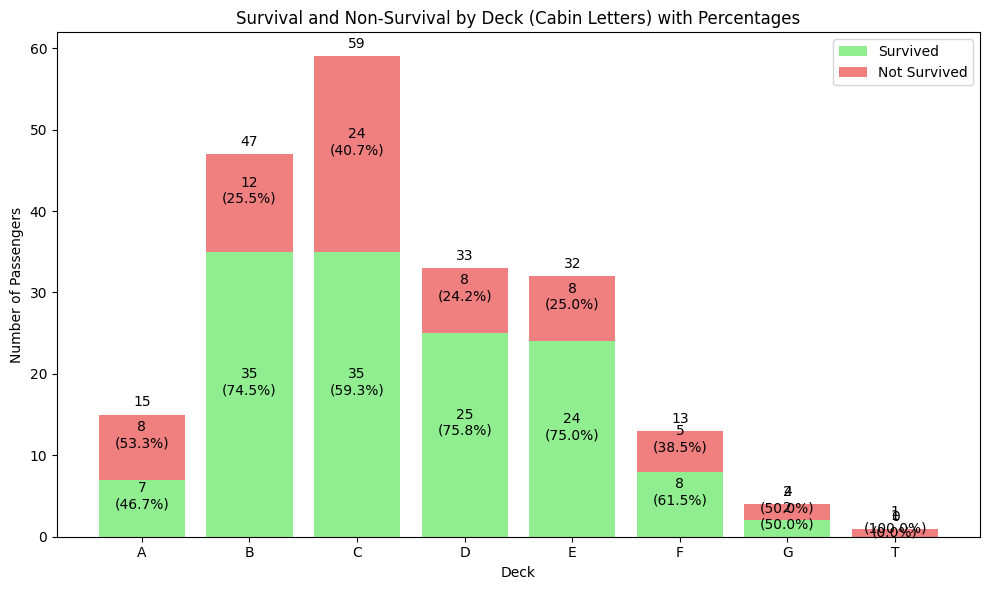

In [66]:
df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])') # Извлечение первой буквы (палубы) из столбца Cabin
deck_grouped = df.groupby(['Deck', 'Survived']).size().unstack(fill_value=0) # Группировка по палубе (Deck) и статусу выживаемости (Survived)

# Рассчитываем проценты для каждой палубы
deck_grouped['Total'] = deck_grouped[0] + deck_grouped[1]
deck_grouped['Survived (%)'] = (deck_grouped[1] / deck_grouped['Total']) * 100
deck_grouped['Not Survived (%)'] = (deck_grouped[0] / deck_grouped['Total']) * 100

plt.figure(figsize=(10, 6))

plt.bar(deck_grouped.index.astype(str), deck_grouped[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(deck_grouped.index.astype(str), deck_grouped[0], label='Not Survived', bottom=deck_grouped[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление числовых значений и процентов над столбцами
for idx, (survived, not_survived, survived_pct, not_survived_pct) in enumerate(
        zip(deck_grouped[1], deck_grouped[0], deck_grouped['Survived (%)'], deck_grouped['Not Survived (%)'])):
    total = survived + not_survived
    plt.text(idx, survived + not_survived + 1, f'{total}', ha='center')  # Общее количество пассажиров
    plt.text(idx, survived / 2, f'{survived}\n({survived_pct:.1f}%)', ha='center', color='black')  # Проценты выживших
    plt.text(idx, survived + not_survived / 2, f'{not_survived}\n({not_survived_pct:.1f}%)', ha='center', color='black')  # Проценты невыживших

plt.title('Survival and Non-Survival by Deck (Cabin Letters) with Percentages')
plt.xlabel('Deck')
plt.ylabel('Number of Passengers')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Далее из кабины, я выделил букву, обозначающую палубу на которой находится кабина и вывел график выживаемости в зависимости от палубы. Тут можем увидить что те кто были на палубе B C D E F имели хорошие шансы на выживание. Решил это достаточно полезный признак, которы поможет нейросети.


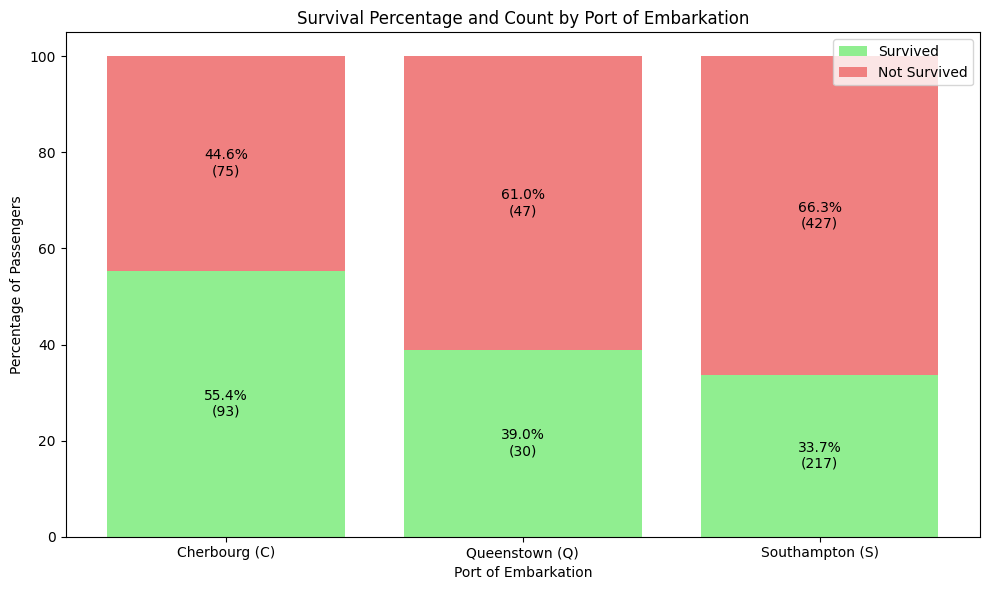

In [67]:
embarked_grouped = df_clean.groupby(['Embarked', 'Survived']).size().unstack(fill_value=0) # Считаем количество выживших и невыживших по каждому порту
embarked_percentage = embarked_grouped.div(embarked_grouped.sum(axis=1), axis=0) * 100 # Переводим абсолютные значения в проценты

plt.figure(figsize=(10, 6))

plt.bar(embarked_percentage.index, embarked_percentage[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(embarked_percentage.index, embarked_percentage[0], label='Not Survived', bottom=embarked_percentage[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление процентных и числовых значений над столбцами
for idx, port in enumerate(embarked_percentage.index):
    survived_count = embarked_grouped.loc[port, 1]
    not_survived_count = embarked_grouped.loc[port, 0]
    survived_pct = embarked_percentage.loc[port, 1]
    not_survived_pct = embarked_percentage.loc[port, 0]

    plt.text(idx, survived_pct / 2, f'{survived_pct:.1f}%\n({survived_count})',
             ha='center', va='center', color='black') # Выжившие
    plt.text(idx, survived_pct + not_survived_pct / 2, f'{not_survived_pct:.1f}%\n({not_survived_count})',
             ha='center', va='center', color='black')  # Невыжившие

plt.title('Survival Percentage and Count by Port of Embarkation')
plt.xlabel('Port of Embarkation')
plt.ylabel('Percentage of Passengers')
plt.xticks(ticks=range(len(embarked_percentage.index)), labels=['Cherbourg (C)', 'Queenstown (Q)', 'Southampton (S)'])
plt.legend()
plt.tight_layout()
plt.show()

Тут я смотрел на зависимость выживания и порта посадки. Каких то особых результатов не получил, да и не понял как оно может влиять на виживаемость. Только случайность или количество людей с определенного места посадки. Но так как все таки оно имеет какой-то вес, решил оставить как есть.

In [68]:
# Признак: Количество пассажиров с одинаковым номером билета
df['TicketGroupSize'] = df.groupby('Ticket')['Ticket'].transform('count')

# Признак: Стоимость билета на одного пассажира
df['FarePerPerson'] = df['Fare'] / df['TicketGroupSize']

# Выделение префиксов из номеров билетов с помощью регулярного выражения
df['TicketPrefix'] = df['Ticket'].str.extract(r'([A-Za-z]+)')

# Замена отсутствующих префиксов значением "None" для удобства анализа
df['TicketPrefix'].fillna('None', inplace=True)

<ipython-input-68-fbb9222667e0>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TicketPrefix'].fillna('None', inplace=True)


Тут уже смотрел по остаточному признаку. Не рассматривал только билеты и решил посмотреть на их повторения, высчитал цену на человека и выделил префиксы.

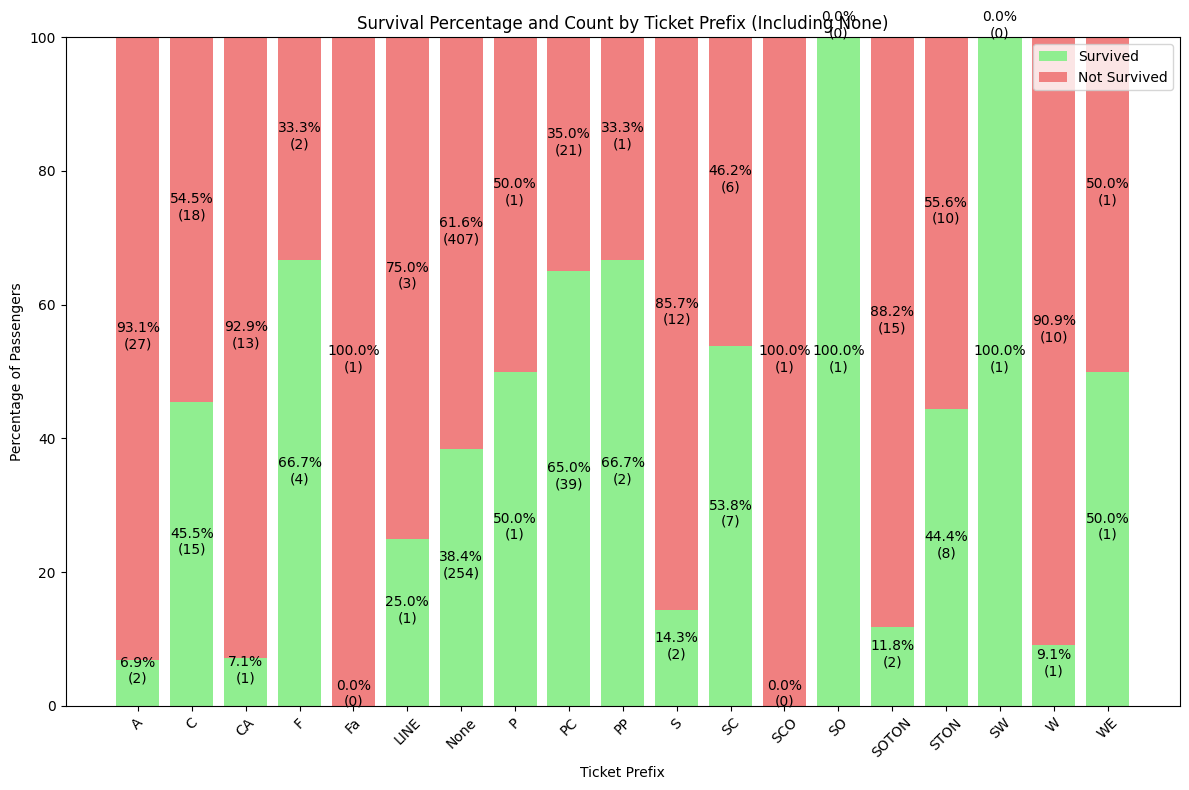

In [69]:
df['TicketPrefix'] = df['Ticket'].str.extract(r'([A-Za-z]+)').fillna('None')

ticket_prefix_grouped = df.groupby(['TicketPrefix', 'Survived']).size().unstack(fill_value=0) # Группировка по префиксу билета и выживанию
ticket_prefix_percentage = ticket_prefix_grouped.div(ticket_prefix_grouped.sum(axis=1), axis=0) * 100  # Переводим абсолютные значения в проценты выживаемости

plt.figure(figsize=(12, 8))

plt.bar(ticket_prefix_percentage.index, ticket_prefix_percentage[1], label='Survived', color='lightgreen') # Гистограмма для выживших (Survived = 1)
plt.bar(ticket_prefix_percentage.index, ticket_prefix_percentage[0], label='Not Survived', bottom=ticket_prefix_percentage[1], color='lightcoral') # Гистограмма для невыживших (Survived = 0)

# Добавление процентных значений и чисел пассажиров над столбцами
for idx, prefix in enumerate(ticket_prefix_percentage.index):
    survived_pct = ticket_prefix_percentage.loc[prefix, 1]
    not_survived_pct = ticket_prefix_percentage.loc[prefix, 0]
    total_count = ticket_prefix_grouped.loc[prefix].sum()


    plt.text(idx, survived_pct / 2, f'{survived_pct:.1f}%\n({ticket_prefix_grouped.loc[prefix, 1]})',
             ha='center', color='black')  # Процент выживших

    plt.text(idx, survived_pct + not_survived_pct / 2, f'{not_survived_pct:.1f}%\n({ticket_prefix_grouped.loc[prefix, 0]})',
             ha='center', color='black')  # Процент невыживших

plt.title('Survival Percentage and Count by Ticket Prefix (Including None)')
plt.xlabel('Ticket Prefix')
plt.ylabel('Percentage of Passengers')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Тут посмотрел зависимость выживания от префиксса. Особые выводы сделать сложно. По префиксу может быть можно выделить палубу или тп, но каких либо закономерностей я не увидел

<ipython-input-70-393f7f1c22b0>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fare_grouped = df.groupby(['FareGroup', 'Survived']).size().unstack(fill_value=0) # Группировка по ценовым диапазонам и выживанию


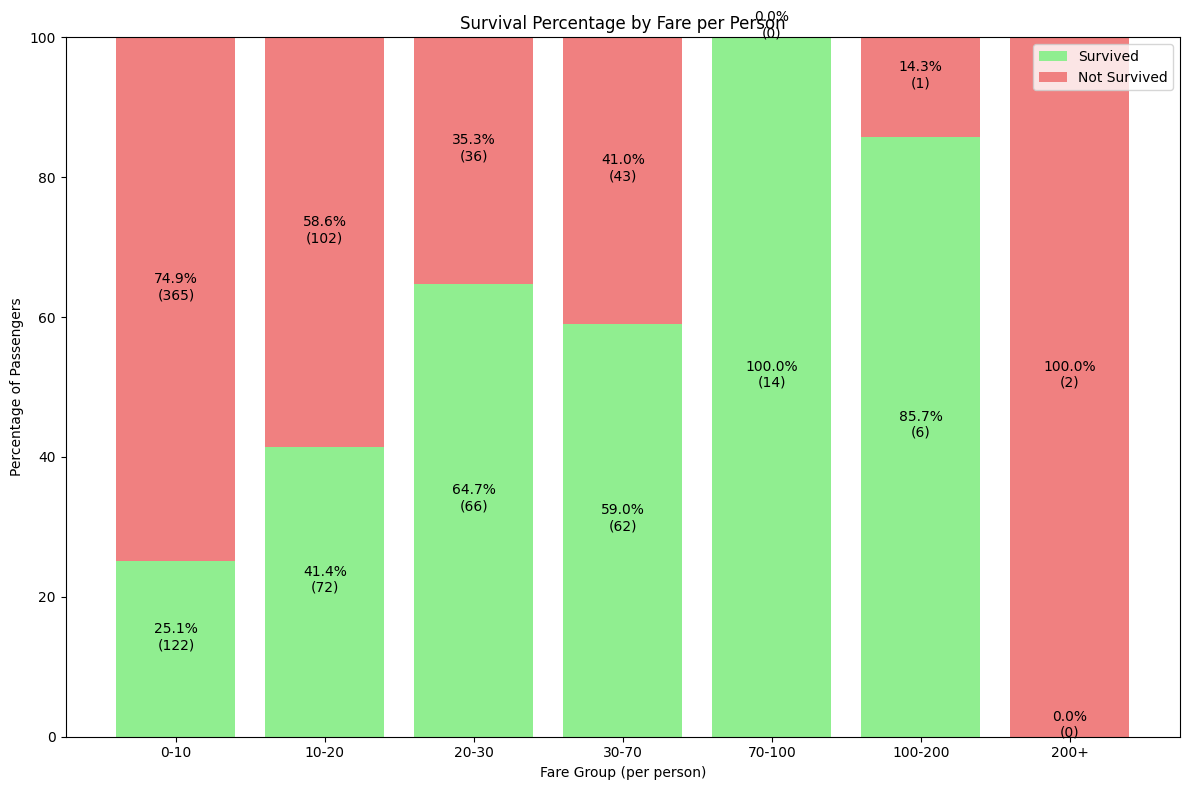

In [70]:
# Разделение на ценовые диапазоны
bins = [-1, 10, 20, 30, 70, 100, 200, df['FarePerPerson'].max()]
labels = ['0-10', '10-20', '20-30',  '30-70', '70-100', '100-200', f'200+']
df['FareGroup'] = pd.cut(df['FarePerPerson'], bins=bins, labels=labels)

fare_grouped = df.groupby(['FareGroup', 'Survived']).size().unstack(fill_value=0) # Группировка по ценовым диапазонам и выживанию
fare_group_percentage = fare_grouped.div(fare_grouped.sum(axis=1), axis=0) * 100 # Перевод абсолютных значений в проценты выживаемости

plt.figure(figsize=(12, 8))

plt.bar(fare_group_percentage.index, fare_group_percentage[1], label='Survived', color='lightgreen') # Гистограмма для выживших
plt.bar(fare_group_percentage.index, fare_group_percentage[0], label='Not Survived', bottom=fare_group_percentage[1], color='lightcoral') # Гистограмма для невыживших

# Добавление процентных значений и чисел пассажиров над столбцами
for idx, fare_range in enumerate(fare_group_percentage.index):
    survived_pct = fare_group_percentage.loc[fare_range, 1]
    not_survived_pct = fare_group_percentage.loc[fare_range, 0]
    total_count = fare_grouped.loc[fare_range].sum()


    plt.text(idx, survived_pct / 2, f'{survived_pct:.1f}%\n({fare_grouped.loc[fare_range, 1]})',
             ha='center', color='black') # Процент выживших

    plt.text(idx, survived_pct + not_survived_pct / 2, f'{not_survived_pct:.1f}%\n({fare_grouped.loc[fare_range, 0]})',
             ha='center', color='black') # Процент невыживших

plt.title('Survival Percentage by Fare per Person')
plt.xlabel('Fare Group (per person)')
plt.ylabel('Percentage of Passengers')
plt.legend()
plt.tight_layout()
plt.show()

In [71]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Title,Deck,TicketGroupSize,FarePerPerson,TicketPrefix,FareGroup
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1,Mr,NaN,1,7.2500,A,0-10
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,Mrs,C,1,71.2833,PC,70-100
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss,NaN,1,7.9250,STON,0-10
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,Mrs,C,2,26.5500,None,20-30
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,Mr,NaN,1,8.0500,None,0-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,0,Mr,NaN,1,13.0000,None,10-20
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,0,Miss,B,1,30.0000,None,20-30
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,3,Miss,NaN,2,11.7250,W,10-20
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0,Mr,C,1,30.0000,None,20-30


Тут уже правильный график на котором можно увидеть что чем дороже билет, тем больше шанс выжить, но это не коснулось самых дорогих билетов (я думаю там сыграл фактор случайности или что-то другое). В принципе график более чем полезный.

## Стараемся привести датасет к нужному состоянию

In [72]:
df.isnull().sum() # Проверяем на отсутствие данных и видим пропуски в 3 столбцах

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [73]:
df['Embarked'].value_counts() # Проверил распределение значений

,count
Embarked,
S,644
C,168
Q,77


In [74]:
df['Embarked'] = df['Embarked'].fillna("S") # Заменил пропущенные значения в столбике 'Embarked' на самое расспространенное

In [75]:
median_ages = df.groupby('Title')['Age'].median() # группируем по титулам и заполняем пропуски средним возрастом по титулу
df['Age'] = df.apply(lambda row: median_ages[row['Title']] if pd.isnull(row['Age']) else row['Age'], axis=1)
df['Age Group'] = pd.cut(df['Age'], bins=range(0, 81, 10)) # заполним группы возрастов так чтобы не было пропусков
df.isnull().sum() # Проверяем что пропусков не осталось

,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687


In [76]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# С помощью feature engineering добавил новые признаки - Relatives	Title	Deck	TicketGroupSize	FarePerPerson	TicketPrefix	FareGroup	Age Group.


In [77]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Title,Deck,TicketGroupSize,FarePerPerson,TicketPrefix,FareGroup,Age Group
0,0,3,108,1,22.0,1,0,523,7.2500,147,2,1,2,8,1,7.2500,0,0,2
1,1,1,190,0,38.0,1,0,596,71.2833,81,0,1,3,2,1,71.2833,8,6,3
2,1,3,353,0,26.0,0,0,669,7.9250,147,2,0,1,8,1,7.9250,15,0,2
3,1,1,272,0,35.0,1,0,49,53.1000,55,2,1,3,2,2,26.5500,6,3,3
4,0,3,15,1,35.0,0,0,472,8.0500,147,2,0,2,8,1,8.0500,6,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,548,1,27.0,0,0,101,13.0000,147,2,0,2,8,1,13.0000,6,1,2
887,1,1,303,0,19.0,0,0,14,30.0000,30,2,0,1,1,1,30.0000,6,3,1
888,0,3,413,0,22.0,1,2,675,23.4500,147,2,3,1,8,2,11.7250,17,1,2
889,1,1,81,1,26.0,0,0,8,30.0000,60,0,0,2,2,1,30.0000,6,3,2


In [78]:
df.corr()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Relatives,Title,Deck,TicketGroupSize,FarePerPerson,TicketPrefix,FareGroup,Age Group
Survived,1.000000,-0.338481,-0.057343,-0.543351,-0.076500,-0.035322,0.081629,-0.164549,0.257307,-0.254888,-0.167675,0.016639,-0.081541,-0.301116,0.038247,0.254824,0.030179,0.319471,-0.039581
Pclass,-0.338481,1.000000,0.052831,0.131900,-0.350667,0.083081,0.018443,0.319869,-0.549500,0.684121,0.162098,0.065997,-0.107466,0.746616,-0.002633,-0.655559,-0.070425,-0.867912,-0.347500
Name,-0.057343,0.052831,1.000000,0.020314,0.048518,-0.017230,-0.049105,0.047348,-0.049173,0.061959,-0.006117,-0.036309,0.010480,0.051093,-0.049435,-0.020366,-0.031360,-0.040030,0.035950
Sex,-0.543351,0.131900,0.020314,1.000000,0.099934,-0.114631,-0.245489,0.059372,-0.182333,0.096681,0.108262,-0.200988,0.041667,0.123076,-0.154748,-0.128809,-0.027749,-0.163511,0.053033
Age,-0.076500,-0.350667,0.048518,0.099934,1.000000,-0.263963,-0.187950,-0.073224,0.097282,-0.245347,-0.016971,-0.274306,0.497901,-0.260238,-0.237736,0.219360,0.031955,0.333693,0.971300
SibSp,-0.035322,0.083081,-0.017230,-0.114631,-0.263963,1.000000,0.414838,0.079461,0.159651,0.043593,0.068230,0.890712,-0.219527,0.041540,0.661622,-0.012298,-0.121386,-0.032798,-0.238049
Parch,0.081629,0.018443,-0.049105,-0.245489,-0.187950,0.414838,1.000000,0.020003,0.216225,-0.028324,0.039798,0.783111,-0.100819,-0.032548,0.593076,0.060240,-0.043596,0.000038,-0.160700
Ticket,-0.164549,0.319869,0.047348,0.059372,-0.073224,0.079461,0.020003,1.000000,-0.013885,0.243696,-0.001729,0.064302,-0.045883,0.256307,0.017907,-0.055367,0.260427,-0.232103,-0.066411
Fare,0.257307,-0.549500,-0.049173,-0.182333,0.097282,0.159651,0.216225,-0.013885,1.000000,-0.503355,-0.224719,0.217138,-0.026300,-0.523013,0.345541,0.839037,0.064564,0.573434,0.107301
Cabin,-0.254888,0.684121,0.061959,0.096681,-0.245347,0.043593,-0.028324,0.243696,-0.503355,1.000000,0.202520,0.015644,-0.034369,0.947729,-0.027918,-0.565999,-0.062621,-0.678811,-0.241063


Видим, что некоторые значения сильно корелируют, сначала попробуем обучить со всеми значениями, затем удалив все корелирующие.


In [79]:
df = df.drop(['Cabin', 'Ticket', 'Fare', 'SibSp', 'Parch', 'Name', 'Age','FarePerPerson'], axis=1)

In [80]:
df

,Survived,Pclass,Sex,Embarked,Relatives,Title,Deck,TicketGroupSize,TicketPrefix,FareGroup,Age Group
0,0,3,1,2,1,2,8,1,0,0,2
1,1,1,0,0,1,3,2,1,8,6,3
2,1,3,0,2,0,1,8,1,15,0,2
3,1,1,0,2,1,3,2,2,6,3,3
4,0,3,1,2,0,2,8,1,6,0,3
...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,1,2,0,2,8,1,6,1,2
887,1,1,0,2,0,1,1,1,6,3,1
888,0,3,0,2,3,1,8,2,17,1,2
889,1,1,1,0,0,2,2,1,6,3,2


# Создание нейросети (эксперименты)

In [82]:
X = df.drop(columns=['Survived'])
y = df['Survived']

Разделяем датасет на 2 части


In [83]:
def plot_training_results(history, model, X_test, y_test):
    # Выводим график потерь
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    plt.show()

    # Выводим график точности
    plt.figure(figsize=(5, 5))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

    # Определяем предсказания модели
    y_pred = (model.predict(X_test) > 0.5).astype(int)

    # Выводим отчёт классификации
    print(f"\n{classification_report(y_test, y_pred, target_names=['Survived', 'Not Survived'])}\n")

    # Строим матрицу ошибок
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Survived', 'Survived'],
                yticklabels=['Not Survived', 'Survived'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

Делаем функцию для вывода метрик


## 1 вариант Стандартная модель

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3827 - loss: 0.7366 - val_accuracy: 0.3636 - val_loss: 0.6992
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5121 - loss: 0.6725 - val_accuracy: 0.6993 - val_loss: 0.6554
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7389 - loss: 0.6254 - val_accuracy: 0.7273 - val_loss: 0.6163
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7671 - loss: 0.5860 - val_accuracy: 0.7413 - val_loss: 0.5810
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7754 - loss: 0.5589 - val_accuracy: 0.7273 - val_loss: 0.5453
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7743 - loss: 0.5314 - val_accuracy: 0.7413 - val_loss: 0.5110
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7834 - loss: 0.5005 - val_accuracy: 0.7273 - val_loss: 0.4827
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7996 - loss: 0.4768 - val_accuracy: 0.7622 - val_loss: 0.4575
Ep

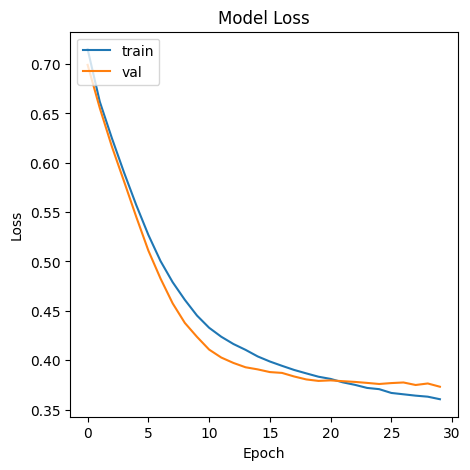

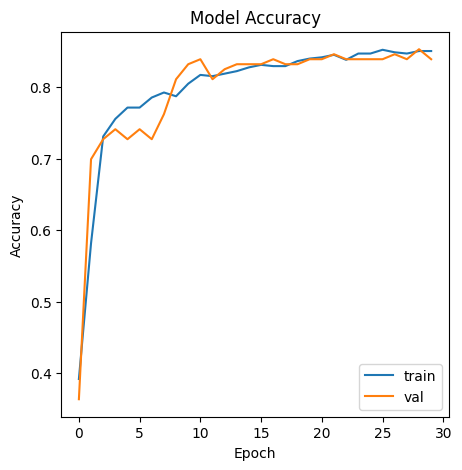

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

              precision    recall  f1-score   support

    Survived       0.84      0.90      0.87       105
Not Survived       0.84      0.76      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179




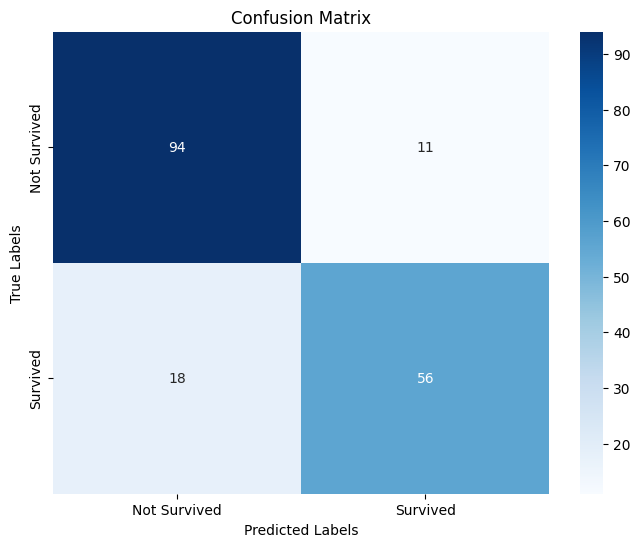

In [58]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

До удаления корелирующих данных. Довольно неплохая точность для самой простой модели, но видим что на эпохах > 20 модель начинает переобучаться, попробуем устранить это.

После удаления корелирующих данных. Графики стали ровнее, результат стал немного лучше. В среднем выдает значения выше


## Вариант 2 Модель с коллбэком early_stopping и слоями dropout


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6704 - loss: 0.6388 - val_accuracy: 0.7483 - val_loss: 0.5443
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7319 - loss: 0.5754 - val_accuracy: 0.8462 - val_loss: 0.4992
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7552 - loss: 0.5495 - val_accuracy: 0.8462 - val_loss: 0.4651
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7765 - loss: 0.5152 - val_accuracy: 0.8462 - val_loss: 0.4431
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7705 - loss: 0.5015 - val_accuracy: 0.8322 - val_loss: 0.4275
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7647 - loss: 0.5120 - val_accuracy: 0.8462 - val_loss: 0.4178
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8083 - loss: 0.4541 - val_accuracy: 0.8531 - val_loss: 0.4084
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7945 - loss: 0.4752 - val_accuracy: 0.8531 - va

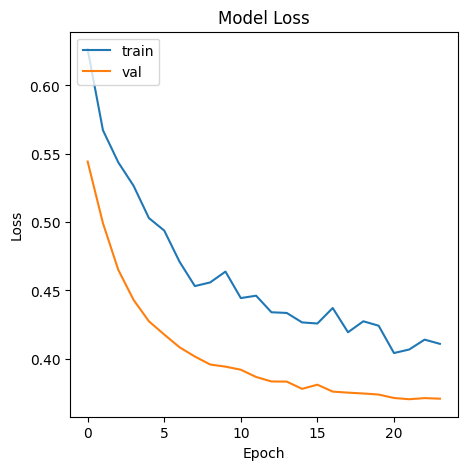

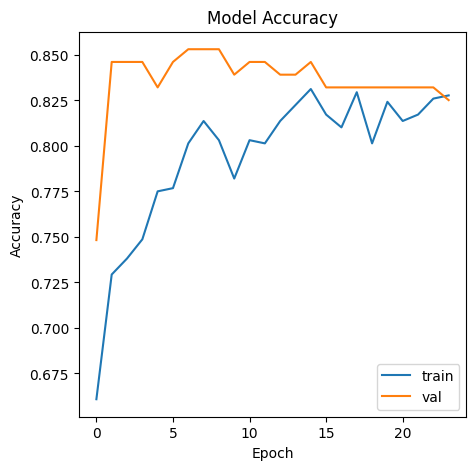

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

              precision    recall  f1-score   support

    Survived       0.84      0.88      0.86       105
Not Survived       0.81      0.77      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.83      0.83      0.83       179




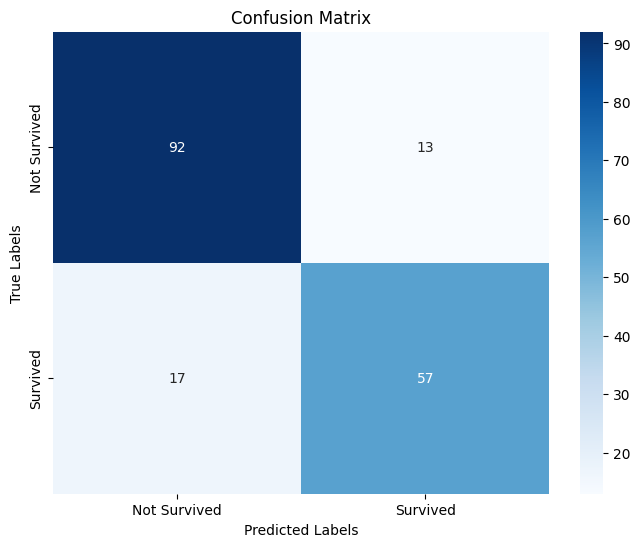

In [71]:
early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks = [early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

До удаления корелирующих данных. Отличная точность, так же страдает от переобучения но уже не так сильно График не очень ровный. Дальше пойдут попытки улучшить модель, но особых результатов они не дали. Они либо ухудшали ее либо ничего не делали. Графики достаточно ровные.

После удаления. График стал ровнее, но результат по ощущениям немного ухудшился, уменьшилась точность. Максимальный результат стал не 0.85 а 0.84. Пропало переобучение

## 3 вариант модель 2 варианта с batchNormalizstion и дополнительнымм наружним слоем с неронами



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.5645 - loss: 0.8616 - val_accuracy: 0.7343 - val_loss: 0.6500
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6904 - loss: 0.6360 - val_accuracy: 0.7273 - val_loss: 0.6028
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7245 - loss: 0.6037 - val_accuracy: 0.7483 - val_loss: 0.5688
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7105 - loss: 0.5892 - val_accuracy: 0.7622 - val_loss: 0.5386
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7739 - loss: 0.5204 - val_accuracy: 0.7832 - val_loss: 0.5118
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7977 - loss: 0.4740 - val_accuracy: 0.7902 - val_loss: 0.4867
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7906 - loss: 0.4824 - val_accuracy: 0.7902 - val_loss: 0.4696
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8006 - loss: 0.5015 - val_accuracy: 0.7972 - val_loss

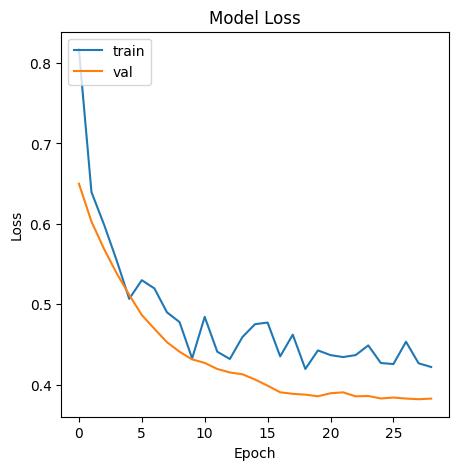

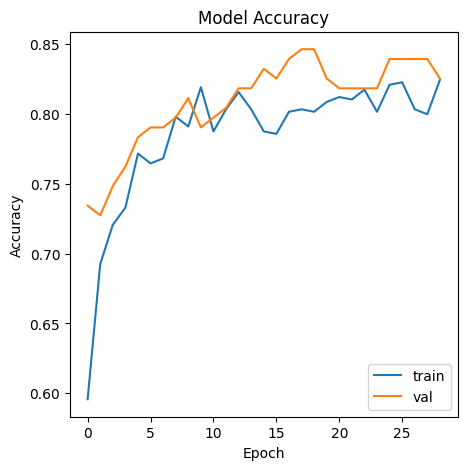

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

              precision    recall  f1-score   support

    Survived       0.82      0.90      0.86       105
Not Survived       0.84      0.72      0.77        74

    accuracy                           0.83       179
   macro avg       0.83      0.81      0.82       179
weighted avg       0.83      0.83      0.82       179




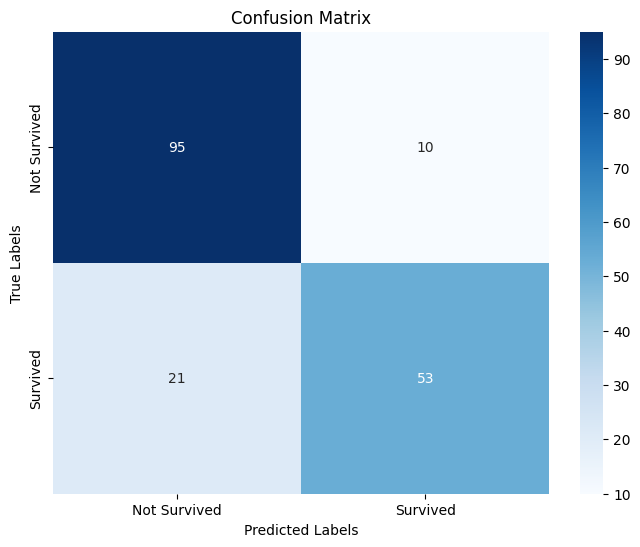

In [74]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model

model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))  # Увеличиваем количество нейронов
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks = [early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

До удаления корелирующих данных. Результат не улучшился, графики стали дерганными.

После удаления. Графики стали поплавнее и результат выше

## 4 вариант 2 модель с добавлением еще 2 слоев с нейронами



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 88ms/step - accuracy: 0.5995 - loss: 0.6929 - val_accuracy: 0.6503 - val_loss: 0.6912
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6015 - loss: 0.6914 - val_accuracy: 0.6503 - val_loss: 0.6890
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6360 - loss: 0.6890 - val_accuracy: 0.6503 - val_loss: 0.6870
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6307 - loss: 0.6873 - val_accuracy: 0.6503 - val_loss: 0.6848
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6201 - loss: 0.6852 - val_accuracy: 0.6503 - val_loss: 0.6811
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6295 - loss: 0.6805 - val_accuracy: 0.6503 - val_loss: 0.6762
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6355 - loss: 0.6777 - val_accuracy: 0.6503 - val_loss: 0.6664
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6165 - loss: 0.6700 - val_accuracy: 0.6503 - v

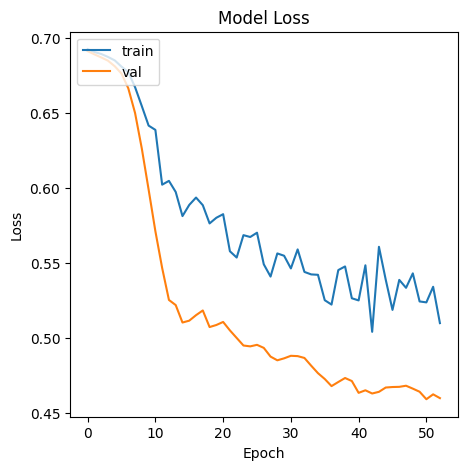

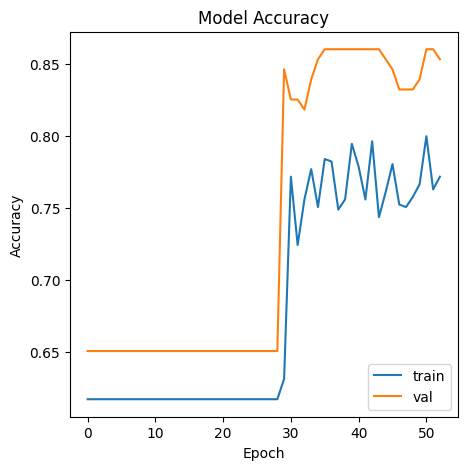

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

              precision    recall  f1-score   support

    Survived       0.83      0.87      0.85       105
Not Survived       0.80      0.74      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.80      0.81       179
weighted avg       0.81      0.82      0.81       179




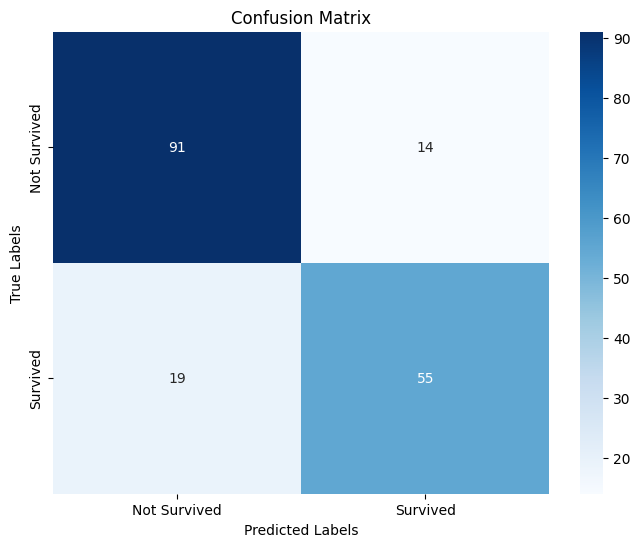

In [78]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.2))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(4, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(2, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks = [early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

До удаления. Результаты почти не изменились, но графики стали немного лучше. Практически пропало переобучение

После удаления. Графики так же улучшились и результат стал выше. но иногда наблюдается совсем обратная картина.


## 5 вариант 2 вариант нейросети с sheduler`ом и оптимайзером с меняющейся скоростью обучения


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5939 - loss: 0.6590 - val_accuracy: 0.7622 - val_loss: 0.5778 - learning_rate: 0.0010
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7307 - loss: 0.5920 - val_accuracy: 0.7552 - val_loss: 0.5234 - learning_rate: 0.0010
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7191 - loss: 0.5460 - val_accuracy: 0.7762 - val_loss: 0.4962 - learning_rate: 9.5000e-04
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7699 - loss: 0.5303 - val_accuracy: 0.7762 - val_loss: 0.4777 - learning_rate: 9.5000e-04
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7786 - loss: 0.4902 - val_accuracy: 0.7762 - val_loss: 0.4624 - learning_rate: 9.0250e-04
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7755 - loss: 0.5055 - val_accuracy: 0.7972 - val_loss: 0.4479 - learning_rate: 9.0250e-04
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7807 - loss: 0.4580 - val_accu

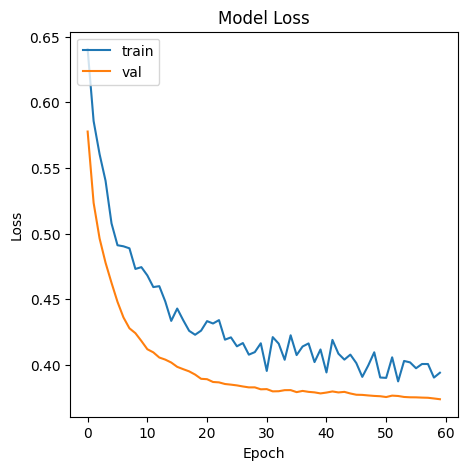

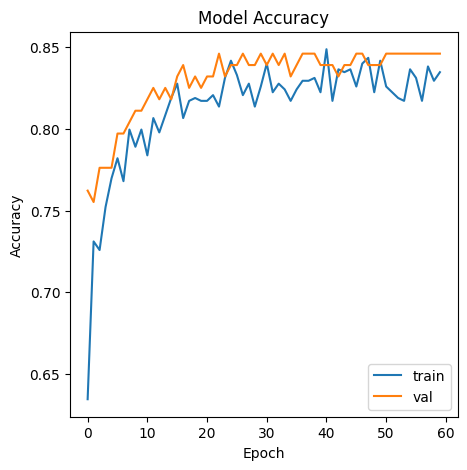

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

              precision    recall  f1-score   support

    Survived       0.83      0.86      0.85       105
Not Survived       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179




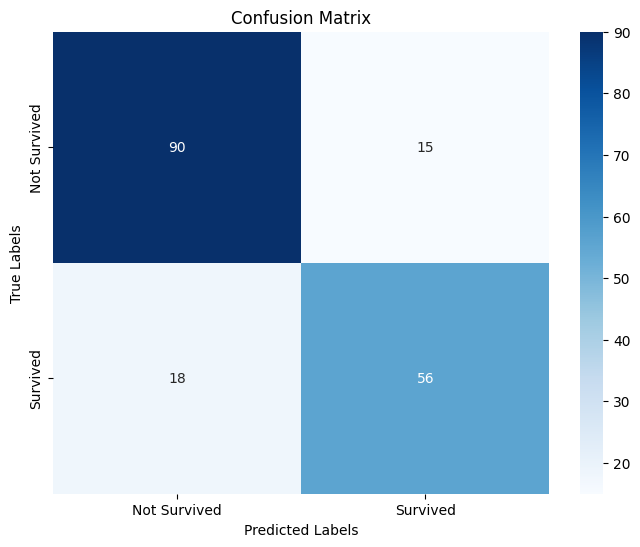

In [79]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.1))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)
def scheduler(epoch, lr):
    if epoch % 2 == 0 and epoch:
        lr *= 0.95
    return lr

lr_scheduler = LearningRateScheduler(scheduler)
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks = [early_stopping,lr_scheduler])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

Результат не изменился, появилось переобучение. Улучшений не произошло

После удаления. Графики стали немного лучше, но увеличелось количество скачков результат - график стал дерганым.

## 6 вариант Постарался сделать модель которая включает в себя практически все что я делал и как то положительно влияло на результат.


Epoch 1/60


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7301 - loss: 0.7524 - val_accuracy: 0.8322 - val_loss: 0.5388
Epoch 2/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7904 - loss: 0.5909 - val_accuracy: 0.7972 - val_loss: 0.5076
Epoch 3/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7905 - loss: 0.5355 - val_accuracy: 0.8322 - val_loss: 0.4554
Epoch 4/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7987 - loss: 0.4909 - val_accuracy: 0.8462 - val_loss: 0.4403
Epoch 5/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8185 - loss: 0.4664 - val_accuracy: 0.8322 - val_loss: 0.4338
Epoch 6/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7920 - loss: 0.4871 - val_accuracy: 0.8182 - val_loss: 0.4346
Epoch 7/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8099 - loss: 0.4402 - val_accuracy: 0.8462 - val_loss: 0.4211
Epoch 8/60
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8071 - loss: 0.4423 - val_accuracy: 0.8392 - val_loss: 0.4255

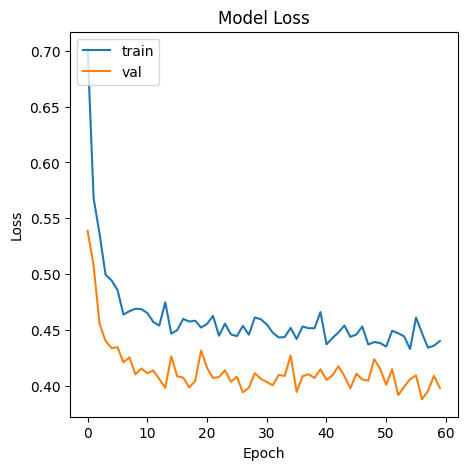

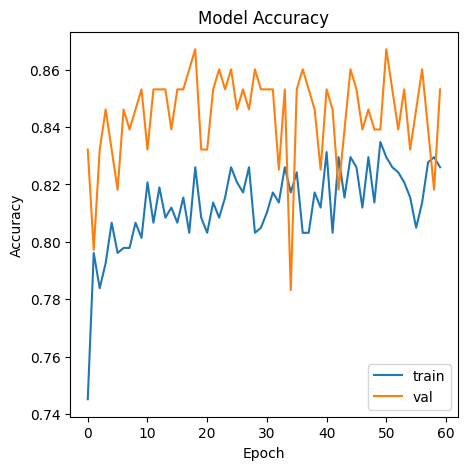

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

              precision    recall  f1-score   support

    Survived       0.83      0.85      0.84       105
Not Survived       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179




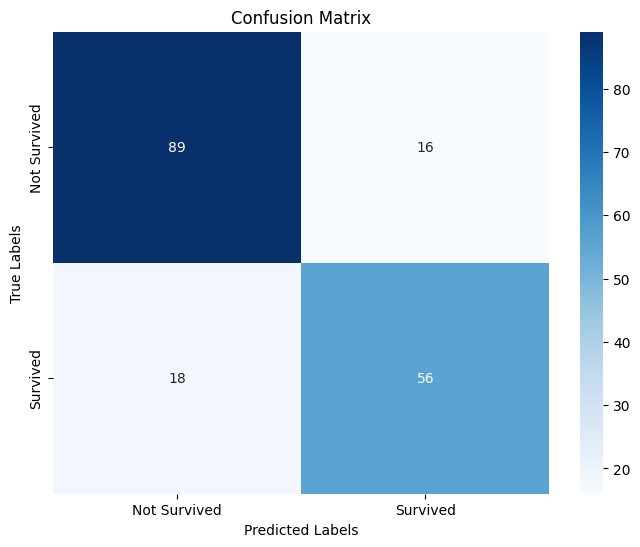

In [80]:
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create the neural network model
model = Sequential()

model.add(Dense(32, kernel_regularizer=l2(0.001)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.1))

model.add(Dense(16, kernel_regularizer=l2(0.01)))
model.add(LeakyReLU(alpha=0.5))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.01)

lr_scheduler = LearningRateScheduler(scheduler)
# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_split=0.2, callbacks = [early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(history, model, X_test, y_test)

Эта модель справляетмя уже лучше, но 2 вариант все еще остается фаворитом. Мне кажется что данный датасет из-за своего маленького размера требует несложной модели.

После удаления. Ситуация стала хуже, графики стали очень дерганными и результат хуже

# Лучшие показатели

2 вариант нейросети показал лучшие результаты. Как в среднем так и максимальный.

Test Accuracy: 0.85


              precision    recall  f1-score   support

    Survived           0.87      0.88      0.87       105
    Not Survived       0.82      0.81      0.82       74
    accuracy                               0.85       179
    macro avg          0.84      0.84      0.84       179
    weighted avg       0.85      0.85      0.85       179

  
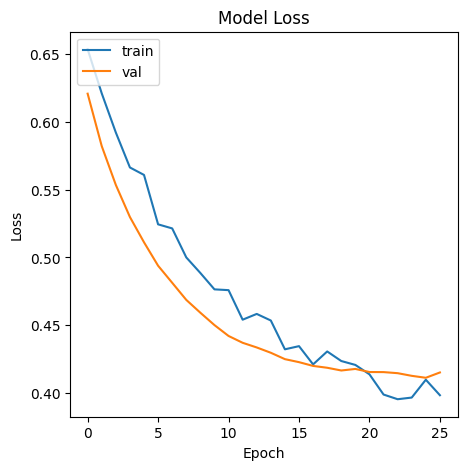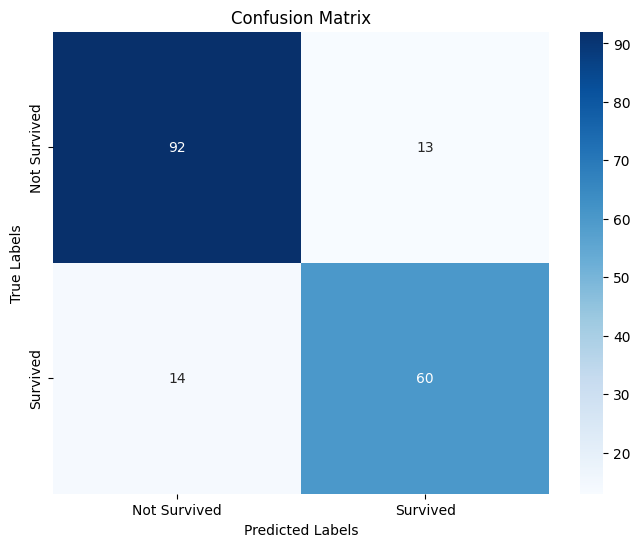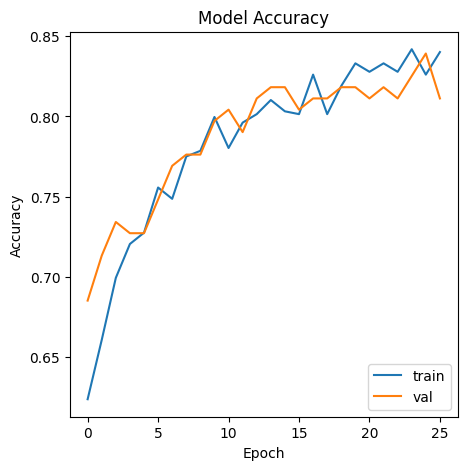




Так как 2 вариант выдает лучшие результаты, поэтому берем его за основу итоговой нейросети.

# Итоговая нейросеть

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


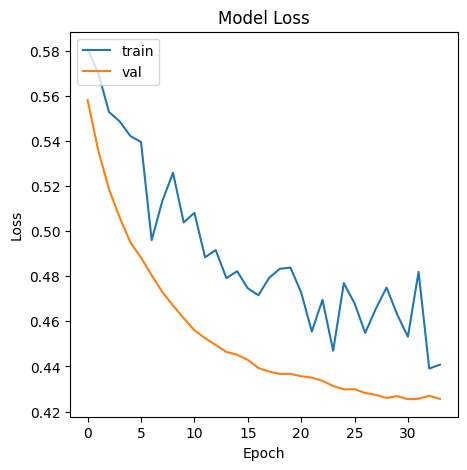

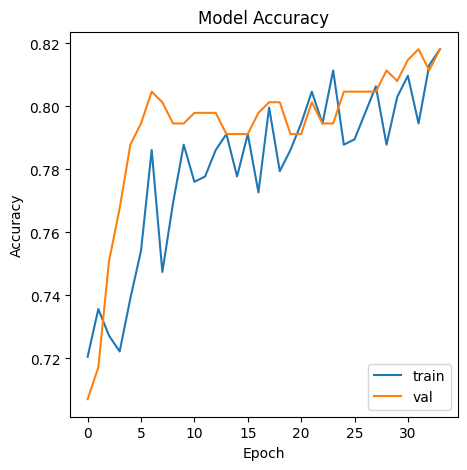

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

              precision    recall  f1-score   support

    Survived       0.84      0.86      0.85       177
Not Survived       0.78      0.75      0.77       120

    accuracy                           0.81       297
   macro avg       0.81      0.80      0.81       297
weighted avg       0.81      0.81      0.81       297




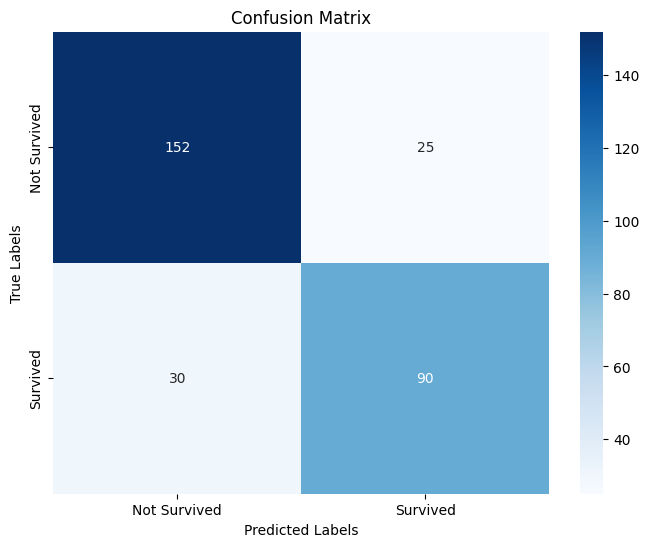




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


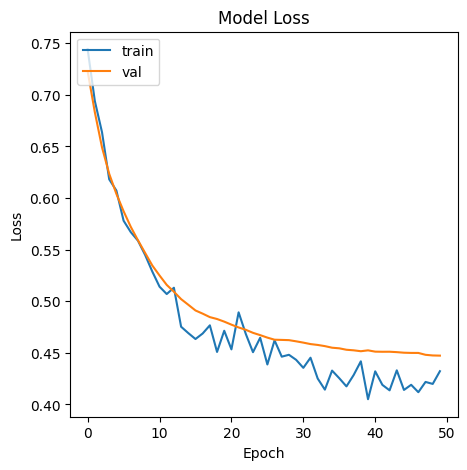

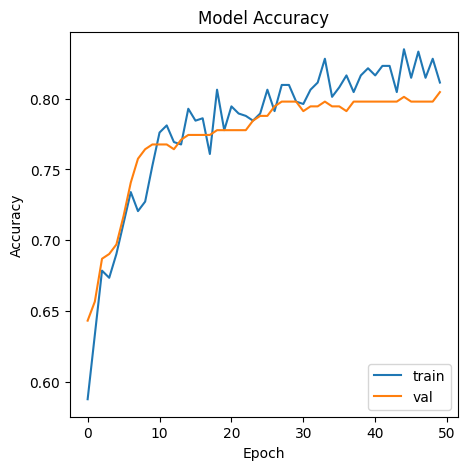

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

              precision    recall  f1-score   support

    Survived       0.84      0.85      0.84       185
Not Survived       0.75      0.73      0.74       112

    accuracy                           0.80       297
   macro avg       0.79      0.79      0.79       297
weighted avg       0.80      0.80      0.80       297




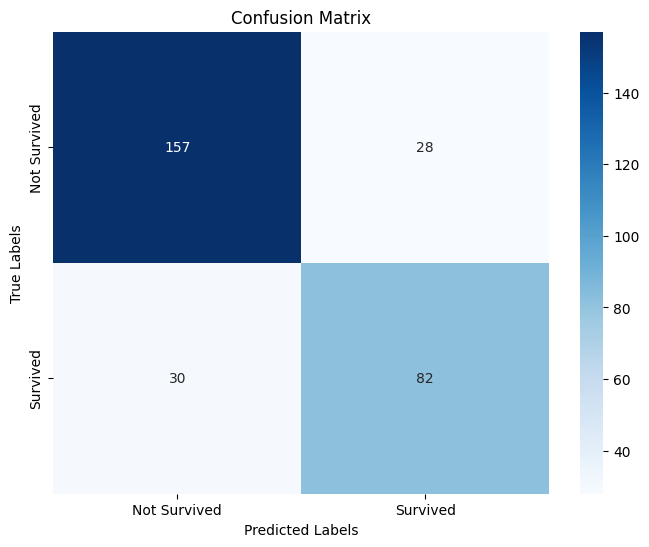




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


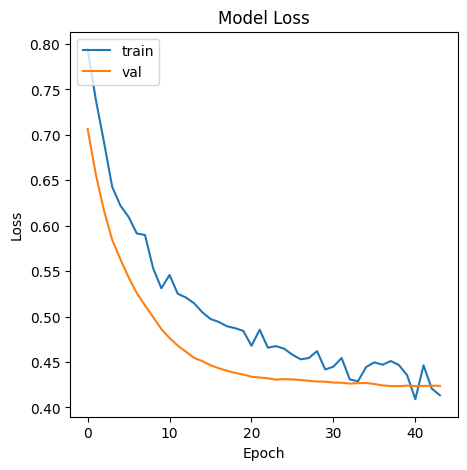

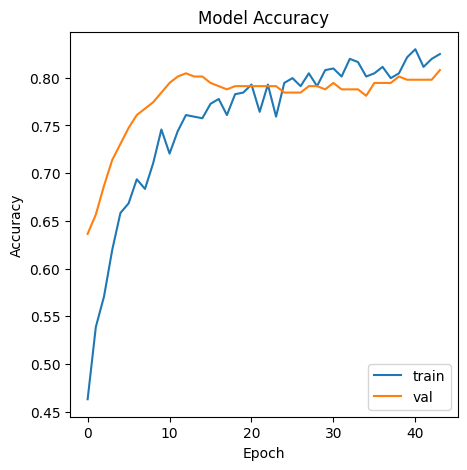

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

              precision    recall  f1-score   support

    Survived       0.84      0.83      0.84       187
Not Survived       0.72      0.74      0.73       110

    accuracy                           0.80       297
   macro avg       0.78      0.79      0.78       297
weighted avg       0.80      0.80      0.80       297




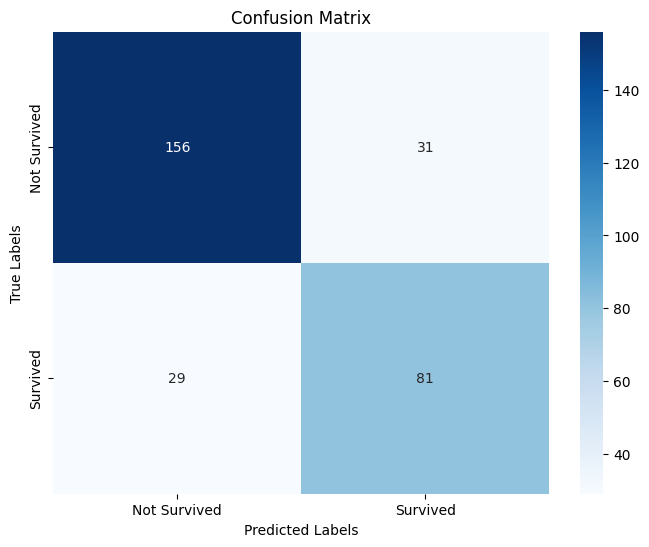




++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++





Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model Best model 


Best Validation Accuracy: 0.8148 from Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8700 - loss: 0.3640 
Test Accuracy: 0.85


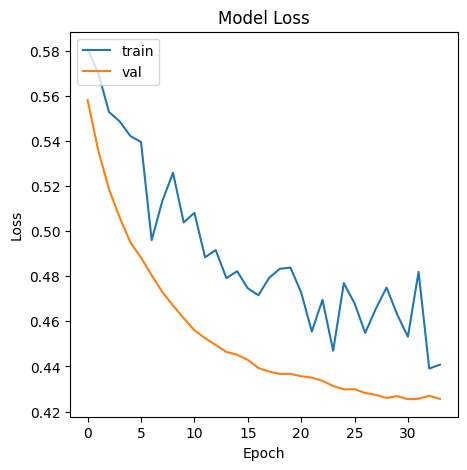

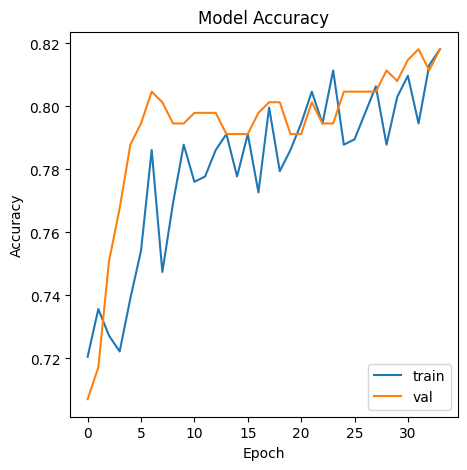

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

              precision    recall  f1-score   support

    Survived       0.88      0.88      0.88       105
Not Survived       0.82      0.82      0.82        74

    accuracy                           0.85       179
   macro avg       0.85      0.85      0.85       179
weighted avg       0.85      0.85      0.85       179




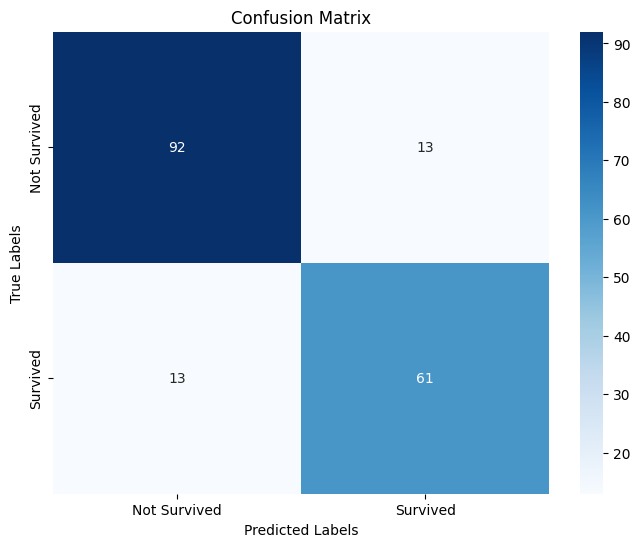

In [126]:
df = pd.get_dummies(df, drop_first=True)

# Определение X и y
X = df.drop('Survived', axis=1).values  # Все столбцы кроме 'Survived'
y = df['Survived'].values  # Столбец 'Survived'

# Нормализация данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Параметры K-Fold
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Создание списка для хранения истории
all_histories = []
accuracy_scores = []

# K-Fold кросс-валидация
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    x_train_fold, x_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Создание модели для каждой итерации
    model = Sequential()
    model.add(Dense(16, activation='relu', input_shape=(X.shape[1],)))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    history = model.fit(x_train_fold, y_train_fold, epochs=50, batch_size=32,
                        validation_data=(x_val_fold, y_val_fold), callbacks=[early_stopping], verbose=0)

    all_histories.append(history)

    val_loss, val_accuracy = model.evaluate(x_val_fold, y_val_fold, verbose=0)
    accuracy_scores.append((history, val_accuracy))

    plot_training_results(history, model, x_val_fold, y_val_fold) # вывод метрик для каждого фолда
    print('\n' + '=' * 200 + '\n')
    print('\n' + '+' * 200 + '\n')
    print('\n' + '=' * 200 + '\n')

print('\n' + '=' * 200 + '\n')
print('Best model ' * 18)
print('\n' + '=' * 200 + '\n')

best_accuracy = max(accuracy_scores, key=lambda x: x[1])  # Находим кортеж с максимальной точностью
best_history = best_accuracy[0]  # История модели с максимальной точностью
best_fold_index = accuracy_scores.index(best_accuracy) + 1  # Индекс фолды с лучшей точностью

print(f'Best Validation Accuracy: {best_accuracy[1]:.4f} from Fold {best_fold_index}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(best_history, model, X_test, y_test)

# Вывод метрик

Best Validation Accuracy: 0.8418 from Fold 1
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9004 - loss: 0.3308 
Test Accuracy: 0.88


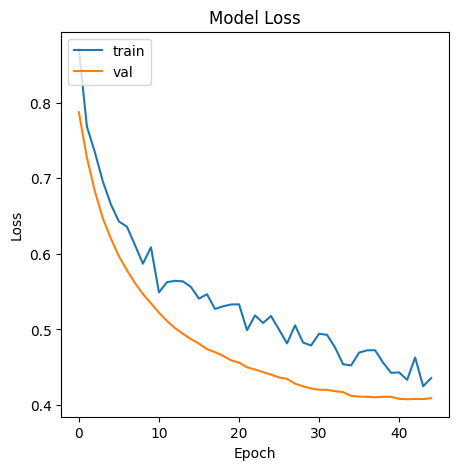

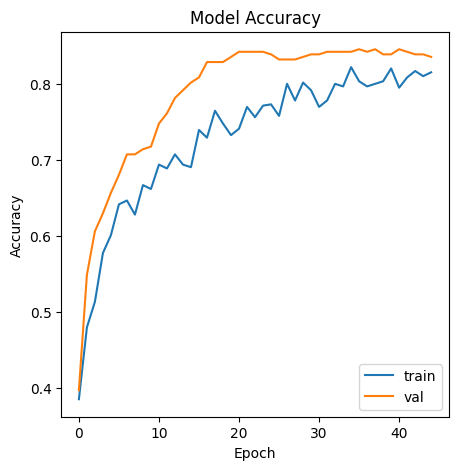

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

              precision    recall  f1-score   support

    Survived       0.86      0.94      0.90       105
Not Survived       0.91      0.78      0.84        74

    accuracy                           0.88       179
   macro avg       0.88      0.86      0.87       179
weighted avg       0.88      0.88      0.88       179




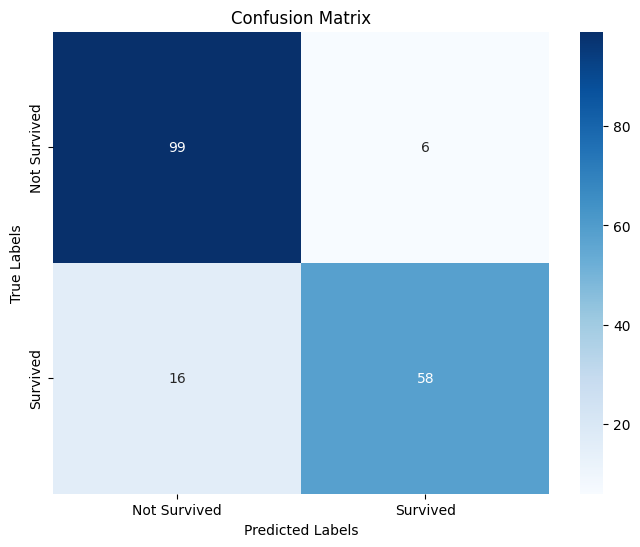

In [120]:
best_accuracy = max(accuracy_scores, key=lambda x: x[1])  # Находим кортеж с максимальной точностью
best_history = best_accuracy[0]  # История модели с максимальной точностью
best_fold_index = accuracy_scores.index(best_accuracy) + 1  # Индекс фолды с лучшей точностью

print(f'Best Validation Accuracy: {best_accuracy[1]:.4f} from Fold {best_fold_index}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

plot_training_results(best_history, model, X_test, y_test)
# Вывод метрик лучшей модели

# Вывод

Лучшая модель которая у меня получилась на валидации выдает точность - 0.8418, а на тестовом датасете 0.88. Все графики и матрицы прилагаются сверху.

## Расшифровка матрицы ошибок
---


1.   модель предсказала, что погибнет, а по факту не погиб = 6 человек
2.   модель предсказала, что погибнет, и действительно погиб = 99 человек


3.   модель предсказала, что не погибнет, а по факту погиб = 16 человек
4.   модель предсказала, что не погибнет, и действительно не погиб = 58 человек

---

Данная модель хорошо определяет погибших людей, и чуть хуже справляется с выжившими, предполагаю все это из-за нехватки информации и возможно из-за недостаточно хорошей архитектуры самой нейросети.

Была проделана достаточно большая работа над анализом. Я постарался выявить самые влиятельные на результат факторы, которые применил при обучении нейросети.Проверил работу нейросети при удаленныйх корелирующих значений и не удаченных. Определенного различия между ними не наблюдал, кроме более ровного графика при удаленных значениях. Поэтому выбрал все таки 2 путь.

Наибольший результат который я смог получить на валидации это 0.85 accuracy на 2 варианте нейросети. Мое предположение это то что на таком маленьком датасете как титаник особо больших архитектур делать не нужно, ведь более простые выдают показатели выше чем сложные.

Сделал кросс-валидацию по самой лучшей модели и вывел результаты для каждого фолда, и для самого лучшего. На тестовых данных итоговая точность - 0.88. Скорее улучшение произошло из-за того что размер тестового датасета был ниже чем валидационного и настоящая точность модели все еще от 0.8 до 0.85.

Для улучшения моей нейросети необходимо провести более глубокий анализ, возможно выявить новые признаки, которые помогут нейросети лучше определять выживших людей, потому что именно в этой части работы у нее возникают трудности. Попробовать использовать больше данных и уменьшить при этом loss.

В целом для первой работы - я думаю что результат вышел нормальным, имеется необходимость лучшего изучения как самой модели так и вещей влияющих на нее.







